# Exporting the Model and Making Final Predictions

In [1]:
import os
import random
import rasterio
import shutil
import math
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
import matplotlib.patches as mpatches
from pathlib import Path
import numpy as np
from contextlib import nullcontext

import torch
import torch.nn as nn
import torch.nn.functional as F
from rasterio.windows import Window
from rasterio.windows import bounds as win_bounds
from rasterio.windows import from_bounds as win_from_bounds
from rasterio.coords import BoundingBox
from rasterio.merge import merge as rio_merge
from rasterio.mask import mask as rio_mask
from rasterio.warp import transform_geom
from rasterio.vrt import WarpedVRT
from rasterio.enums import Resampling
import rasterio.plot

import json
import time
import fiona
from fiona.transform import transform_geom


import tempfile
from rasterio.transform import from_origin
from shapely.geometry import shape
from rasterio.warp import transform_geom
import geopandas as gpd
from shapely.ops import unary_union
from shapely.geometry import box

from collections import Counter

## Data Loading

In [2]:
train_rgb  = Path("../data/train_rgb")
test_rgb   = Path("../data/test_rgb")
train_ndvi = Path("../data/train_ndvi")
test_ndvi  = Path("../data/test_ndvi")

train_rgb_tiles  = sorted([p.name for p in train_rgb.glob("*.tif")])
test_rgb_tiles   = sorted([p.name for p in test_rgb.glob("*.tif")])
train_ndvi_tiles = sorted([p.name for p in train_ndvi.glob("*.tif")])
test_ndvi_tiles  = sorted([p.name for p in test_ndvi.glob("*.tif")])

## Using the selected hyperparameters

### Model Creation

In [4]:
# =========================
# CONFIG for sensitivity runs
# =========================
CFG = {
    # Data / patching
    "patch_size": 512,
    "stride": None,
    "num_epochs": 5,
    "ignore_index": 255,
    "num_classes": 3,

    # Model capacity
    "unet_depth": 5,
    "base_filters": 32,
    "use_batchnorm": True,
    "dropout_p": 0.0,

    # Optimizer / LR
    "optimizer": "adamw",
    "learning_rate": 5e-4,
    "weight_decay": 1e-4,

    # Loss & class imbalance
    "loss_type": "ce",
    "dice_alpha": 0.5,
    "focal_gamma": 2.0,
    "class_weights": "inv",
    "precomputed_counts": None,

    # Training tricks
    "accum_steps": 4,
    "use_amp": True,

    # Augmentations (applied per patch)
    "aug_strength": "none",

    # >>> NEW <<<
    "use_ndvi": True,              # set False to go RGB-only
}

DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"
PATCH_SIZE   = CFG["patch_size"]
STRIDE       = (CFG["patch_size"] // 2) if CFG["stride"] is None else CFG["stride"]
NUM_EPOCHS   = CFG["num_epochs"]
IGNORE_INDEX = CFG["ignore_index"]
NUM_CLASSES  = CFG["num_classes"]
ACCUM_STEPS  = CFG["accum_steps"]
USE_AMP      = CFG["use_amp"]

# =========================
# UNet factory (variable depth/base, BN on/off, dropout)
# =========================
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch, use_bn=True, p_drop=0.0):
        super().__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
        ]
        if use_bn: layers.insert(1, nn.BatchNorm2d(out_ch))
        if p_drop > 0: layers.append(nn.Dropout2d(p_drop))

        layers2 = [
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
        ]
        if use_bn: layers2.insert(1, nn.BatchNorm2d(out_ch))
        if p_drop > 0: layers2.append(nn.Dropout2d(p_drop))

        self.block = nn.Sequential(*layers, *layers2)

    def forward(self, x): return self.block(x)

class UNetFlex(nn.Module):
    """
    depth: number of encoding levels (>=3).
    base:  number of base filters.
    """
    def __init__(self, in_ch=3, n_classes=3, base=32, depth=4, use_bn=True, p_drop=0.0):
        super().__init__()
        assert depth >= 3, "UNet depth must be >= 3"
        self.depth = depth

        # Encoder
        encs = []
        chans = [base * (2**i) for i in range(depth)]
        encs.append(DoubleConv(in_ch, chans[0], use_bn, p_drop))
        for i in range(1, depth):
            encs.append(DoubleConv(chans[i-1], chans[i], use_bn, p_drop))
        self.encs = nn.ModuleList(encs)
        self.pools = nn.ModuleList([nn.MaxPool2d(2) for _ in range(depth-1)])

        # Decoder
        ups  = []
        decs = []
        for i in reversed(range(1, depth)):
            ups.append(nn.ConvTranspose2d(chans[i], chans[i-1], 2, stride=2))
            decs.append(DoubleConv(chans[i] , chans[i-1], use_bn, p_drop))  # concat doubles ch then conv back
        self.ups  = nn.ModuleList(ups)
        self.decs = nn.ModuleList(decs)

        self.out = nn.Conv2d(chans[0], n_classes, 1)

    def forward(self, x):
        feats = []
        z = x
        for i in range(self.depth):
            z = self.encs[i](z)
            feats.append(z)
            if i < self.depth-1:
                z = self.pools[i](z)
        # decode
        for j in range(self.depth-2, -1, -1):
            z = self.ups[self.depth-2 - j](z)
            z = torch.cat([z, feats[j]], dim=1)
            z = self.decs[self.depth-2 - j](z)
        return self.out(z)

# =========================
# Losses (CE, Dice, CE+Dice, Focal)
# =========================
class DiceLoss(nn.Module):
    def __init__(self, ignore_index=255, eps=1e-6):
        super().__init__()
        self.ignore_index = ignore_index
        self.eps = eps

    def forward(self, logits, target):
        # logits: (N,C,H,W), target: (N,H,W) in {0..C-1 or ignore}
        N, C, H, W = logits.shape
        valid = (target != self.ignore_index)
        if not valid.any():
            return logits.new_zeros(())
        target_valid = target.clone()
        target_valid[~valid] = 0

        probs = F.softmax(logits, dim=1)                       # (N,C,H,W)
        probs = probs.permute(0,2,3,1)[valid]                  # (V,C)
        target_oh = F.one_hot(target_valid[valid], num_classes=C).float()  # (V,C)

        inter = (probs * target_oh).sum(dim=0)                 # (C,)
        denom = probs.sum(dim=0) + target_oh.sum(dim=0)        # (C,)
        dice = (2*inter + self.eps) / (denom + self.eps)
        return 1.0 - dice.mean()

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, ignore_index=255, weight=None):
        super().__init__()
        self.gamma = gamma
        self.ignore_index = ignore_index
        self.weight = weight

    def forward(self, logits, target):
        # mask ignore
        valid = (target != self.ignore_index)
        if not valid.any():
            return logits.new_zeros(())
        logits = logits.permute(0,2,3,1)[valid]   # (V,C)
        target = target[valid]                    # (V,)
        logpt = F.log_softmax(logits, dim=-1)
        pt = logpt.exp()
        # gather log prob of true class
        logpt = logpt.gather(1, target.unsqueeze(1)).squeeze(1)
        pt    = pt.gather(1, target.unsqueeze(1)).squeeze(1)
        loss = -(1-pt)**self.gamma * logpt
        if self.weight is not None:
            w = self.weight.to(logits.device)
            loss = loss * w[target]
        return loss.mean()

def make_loss(loss_type="ce", ignore_index=255, class_weights=None, dice_alpha=0.5, focal_gamma=2.0):
    # Accept None | np.ndarray | torch.Tensor
    if isinstance(class_weights, torch.Tensor):
        weight = class_weights  # already on device (ideally)
    elif class_weights is None:
        weight = None
    else:
        weight = torch.tensor(class_weights, dtype=torch.float32)  # CPU for now

    if loss_type == "ce":
        ce = nn.CrossEntropyLoss(ignore_index=ignore_index, weight=weight)
        # ensure weight follows logits device at call time
        def ce_wrap(logits, target):
            if ce.weight is not None and ce.weight.device != logits.device:
                ce.weight = ce.weight.to(logits.device)
            return ce(logits, target)
        return ce_wrap

    elif loss_type == "ce_dice":
        ce = nn.CrossEntropyLoss(ignore_index=ignore_index, weight=weight)
        dice = DiceLoss(ignore_index=ignore_index)
        def mixed(logits, target):
            if ce.weight is not None and ce.weight.device != logits.device:
                ce.weight = ce.weight.to(logits.device)
            return (1 - dice_alpha) * ce(logits, target) + dice_alpha * dice(logits, target)
        return mixed

    elif loss_type == "focal":
        return FocalLoss(gamma=focal_gamma, ignore_index=ignore_index, weight=weight)

    else:
        raise ValueError(f"Unknown loss_type: {loss_type}")


# =========================
# Simple paired augmentations
# =========================
rng = np.random.default_rng(42)

def augment_pair(img_chw, lab_hw, strength="none"):
    if strength == "none":
        return img_chw, lab_hw

    do_h = rng.random() < (0.5 if strength in ("light","medium") else 0.0)
    do_v = rng.random() < (0.2 if strength == "medium" else 0.0)
    krot = (rng.integers(0,4) if strength == "medium" else 0)

    if do_h:
        img_chw = img_chw[:, :, ::-1].copy()
        lab_hw  = lab_hw[:, ::-1].copy()
    if do_v:
        img_chw = img_chw[:, ::-1, :].copy()
        lab_hw  = lab_hw[::-1, :].copy()
    if krot:
        img_chw = np.rot90(img_chw, krot, axes=(-2,-1)).copy()
        lab_hw  = np.rot90(lab_hw,  krot, axes=(-2,-1)).copy()

    # final safety (ensures positive strides & contiguous)
    return np.ascontiguousarray(img_chw), np.ascontiguousarray(lab_hw)


# =========================
# Windowing & normalization
# =========================
def iter_windows_full(height, width, patch, stride):
    max_row = height - patch
    max_col = width  - patch
    if max_row < 0 or max_col < 0:
        return
    for row in range(0, max_row + 1, stride):
        for col in range(0, max_col + 1, stride):
            yield Window(col_off=col, row_off=row, width=patch, height=patch)

def normalize_img(img_hwcn):
    """
    img_hwcn: float32 array (H, W, C). May contain NaN in some channels (e.g., NDVI).
    We compute per-channel mean/std ignoring NaNs.
    """
    img = img_hwcn.astype(np.float32, copy=False)

    # Compute per-channel stats ignoring NaNs
    mean = np.nanmean(img, axis=(0, 1))
    std  = np.nanstd(img,  axis=(0, 1)) + 1e-6

    # Normalise where finite; keep NaNs for now
    img = (img - mean) / std

    # Replace any remaining non-finite with 0 (safe neutral value)
    img[~np.isfinite(img)] = 0.0

    # CHW tensor, contiguous float32
    return np.transpose(img, (2, 0, 1)).astype(np.float32, copy=False).copy()


### Training

In [4]:
rgb_folder_path     = Path("../data/train_rgb")                 # e.g. ../data/5m_rgb
ndvi_folder_path    = Path("../data/train_ndvi")             # NDVI tiles with ..._CIR_lrl.tif
label_train_folder  = Path("../data/lulc_tiles_train")

assert isinstance(train_rgb_tiles, list) and len(train_rgb_tiles) > 0, "train_rgb_tiles is empty or undefined."

# ---------- Compute class weights from training labels ----------
def compute_class_counts(tile_names, label_dir):
    counts = np.zeros(NUM_CLASSES, dtype=np.int64)  # for classes 1..NUM_CLASSES
    for fname in tile_names:
        p = label_dir / fname
        if not p.exists():
            continue
        with rasterio.open(p) as ds:
            lab = ds.read(1)
            for c in range(1, NUM_CLASSES+1):
                counts[c-1] += np.count_nonzero(lab == c)
    return counts

def calc_class_weights(mode, counts):
    if mode == "none" or counts is None:
        return None
    counts = counts.astype(np.float64) + 1e-6
    if mode == "inv":
        w = 1.0 / counts
    elif mode == "sqrt_inv":
        w = 1.0 / np.sqrt(counts)
    elif mode == "precomputed":
        pc = np.asarray(CFG["precomputed_counts"], dtype=np.float64) + 1e-6
        w = 1.0 / pc if CFG["class_weights"] == "inv" else 1.0 / np.sqrt(pc)
        return (w / w.mean()).astype(np.float32)
    else:
        return None
    return (w / w.mean()).astype(np.float32)

counts_for_weights = None
if CFG["class_weights"] in ("inv", "sqrt_inv"):
    print("Computing class counts for weights...")
    counts_for_weights = compute_class_counts(train_rgb_tiles, label_train_folder)
    print("Class counts (1..C):", counts_for_weights.tolist())

class_weights_vec = calc_class_weights(CFG["class_weights"], counts_for_weights)

# ---------- Helper: map RGB filename -> NDVI filename ----------
def rgb_to_ndvi_name(rgb_name: str) -> str:
    if "_RGB_" in rgb_name:
        return rgb_name.replace("_RGB_", "_CIR_")
    # fallback (case-insensitive)
    stem, ext = Path(rgb_name).stem, Path(rgb_name).suffix
    low = stem.lower()
    i = low.find("rgb")
    if i != -1:
        return stem[:i] + "CIR" + stem[i+3:] + ext
    return rgb_name.replace("RGB", "CIR").replace("rgb", "CIR")

# (Optional) If you already have mapping dicts from your split step, you can use them:
# ndvi_by_rgb_train = {rgb: ndvi for rgb, ndvi in zip(train_rgb_tiles, train_ndvi_tiles)}  # if available

# ---------- Build model, optimizer, loss ----------
in_channels = 4 if CFG["use_ndvi"] else 3
model = UNetFlex(
    in_ch=in_channels,
    n_classes=NUM_CLASSES,
    base=CFG["base_filters"],
    depth=CFG["unet_depth"],
    use_bn=CFG["use_batchnorm"],
    p_drop=CFG["dropout_p"]
)

try:
    model = model.to(DEVICE)
except RuntimeError as e:
    if "out of memory" in str(e).lower() and torch.cuda.is_available():
        torch.cuda.empty_cache()
        DEVICE = "cpu"
        model = model.to(DEVICE)
    else:
        raise

# Optimizer
opt_name = CFG["optimizer"].lower()
if opt_name == "adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=CFG["learning_rate"], weight_decay=CFG["weight_decay"])
else:
    optimizer = torch.optim.AdamW(model.parameters(), lr=CFG["learning_rate"], weight_decay=CFG["weight_decay"])

# after you compute class_weights_vec
if class_weights_vec is not None:
    class_weights_t = torch.tensor(class_weights_vec, dtype=torch.float32, device=DEVICE)
else:
    class_weights_t = None

criterion = make_loss(
    loss_type=CFG["loss_type"],
    ignore_index=IGNORE_INDEX,
    class_weights=class_weights_t,   # pass a TENSOR already on DEVICE
    dice_alpha=CFG["dice_alpha"],
    focal_gamma=CFG["focal_gamma"],
)
scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE == "cuda" and USE_AMP))

# ---------- Train ----------
for idx, fname in enumerate(train_rgb_tiles, start=1):
    print(f"{idx}/{len(train_rgb_tiles)}", flush=True)

    rgb_path = rgb_folder_path / fname
    lab_path = label_train_folder / fname
    if not rgb_path.exists() or not lab_path.exists():
        continue

    # Resolve NDVI path if used
    if CFG["use_ndvi"]:
        # If you have ndvi_by_rgb_train dict, use: ndvi_name = ndvi_by_rgb_train.get(fname)
        ndvi_name = rgb_to_ndvi_name(fname)
        ndvi_path = ndvi_folder_path / ndvi_name
        if not ndvi_path.exists():
            print(f"[WARN] NDVI missing for {fname} -> expected {ndvi_path.name}; skipping.")
            continue

    with rasterio.open(rgb_path) as rgb_src, \
         rasterio.open(lab_path) as lab_src, \
         (rasterio.open(ndvi_path) if CFG["use_ndvi"] else nullcontext(None)) as ndvi_src:

        # Grid checks (labels vs RGB)
        if rgb_src.crs != lab_src.crs:
            raise ValueError(f"CRS mismatch for {fname}: RGB {rgb_src.crs} vs LABEL {lab_src.crs}")
        if rgb_src.transform != lab_src.transform:
            raise ValueError(f"Transform mismatch for {fname}. Recreate label tiles to match RGB grid.")
        if (rgb_src.width != lab_src.width) or (rgb_src.height != lab_src.height):
            raise ValueError(f"Size mismatch for {fname}. Recreate label tiles to match RGB size.")

        H, W = rgb_src.height, rgb_src.width
        lab_nodata = lab_src.nodata

        # read label once (RAM)
        label_full = lab_src.read(1)

        # Prepare NDVI reader aligned to RGB (only if used)
        if CFG["use_ndvi"]:
            need_vrt = (ndvi_src.crs != rgb_src.crs) or (ndvi_src.transform != rgb_src.transform) \
                       or (ndvi_src.width != rgb_src.width) or (ndvi_src.height != rgb_src.height)
            if need_vrt:
                ndvi_reader = WarpedVRT(
                    ndvi_src,
                    crs=rgb_src.crs,
                    transform=rgb_src.transform,
                    width=rgb_src.width,
                    height=rgb_src.height,
                    resampling=Resampling.bilinear,  # continuous
                )
            else:
                ndvi_reader = ndvi_src

        for epoch in range(NUM_EPOCHS):
            optimizer.zero_grad(set_to_none=True)
            accum_count = 0

            for win in iter_windows_full(H, W, PATCH_SIZE, STRIDE):
                # ---- RGB patch ----
                rgb_patch = rgb_src.read([1, 2, 3], window=win, out_dtype=np.uint16)  # (3,h,w)

               # ---- NDVI patch (optional) ----
                if CFG["use_ndvi"]:
                    # Read as masked to respect input nodata; keep as float32
                    ndvi_ma = ndvi_reader.read(1, window=win, masked=True).astype(np.float32)  # MaskedArray (h, w)
                    ndvi_data = ndvi_ma.filled(np.nan)  # nodata -> NaN
                    # NDVI should live in [-1, 1]; clip outliers
                    ndvi_data = np.clip(ndvi_data, -1.0, 1.0)

                    # Stack with RGB
                    # (RGB comes as uint16; cast to float before stacking)
                    rgb_patch = rgb_src.read([1, 2, 3], window=win, out_dtype=np.uint16).astype(np.float32)  # (3,h,w)
                    ndvi_patch = ndvi_data[np.newaxis, ...]  # (1,h,w)
                    img_patch = np.concatenate([rgb_patch, ndvi_patch], axis=0)  # (4,h,w)
                    img_hwcn  = np.transpose(img_patch, (1, 2, 0))               # (h,w,4)
                else:
                    rgb_patch = rgb_src.read([1, 2, 3], window=win, out_dtype=np.uint16).astype(np.float32)
                    img_hwcn  = np.transpose(rgb_patch, (1, 2, 0))               # (h,w,3)


                img_chw = normalize_img(img_hwcn)  # (C,H,W) where C = 3 or 4

                # ---- Label patch from RAM ----
                r0, c0, h, w = int(win.row_off), int(win.col_off), int(win.height), int(win.width)
                lab_patch = label_full[r0:r0+h, c0:c0+w]

                # ---- Sanitize labels ----
                lab = lab_patch.astype(np.int64)
                if lab_nodata is not None:
                    lab[lab == lab_nodata] = IGNORE_INDEX
                invalid = (lab < 1) | (lab > NUM_CLASSES)
                lab[invalid] = IGNORE_INDEX
                valid = (lab != IGNORE_INDEX)
                if not np.any(valid):
                    continue
                lab[valid] -= 1  # 1..C -> 0..C-1

                # ---- Augment (paired) ----
                img_chw, lab = augment_pair(img_chw, lab, strength=CFG["aug_strength"])

                # ---- Tensors ----
                x = torch.from_numpy(img_chw).unsqueeze(0).to(DEVICE)
                y = torch.from_numpy(lab).unsqueeze(0).to(DEVICE)

                # ---- Forward / loss / backward ----
                model.train()
                with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda" and USE_AMP)):
                    logits = model(x)
                    loss = criterion(logits, y) if callable(criterion) else criterion(logits, y)
                    loss = loss / ACCUM_STEPS

                scaler.scale(loss).backward()
                accum_count += 1

                if accum_count % ACCUM_STEPS == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad(set_to_none=True)
                    accum_count = 0

            # flush leftovers
            if accum_count > 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)

        if CFG["use_ndvi"] and ndvi_reader is not ndvi_src:
            ndvi_reader.close()

Computing class counts for weights...
Class counts (1..C): [1556645, 2189268, 1117898]
1/14
2/14
3/14
4/14
5/14
6/14
7/14
8/14
9/14
10/14
11/14
12/14
13/14
14/14


### Testing

In [5]:
rgb_folder_path   = Path("../data/test_rgb")
ndvi_folder_path  = Path("../data/test_ndvi")
label_test_folder = Path("../data/lulc_tiles_test")

assert isinstance(test_rgb_tiles, list) and len(test_rgb_tiles) > 0, "test_rgb_tiles list is empty or undefined."
model.eval()

# --- Global confusion matrix ---
cm = np.zeros((NUM_CLASSES, NUM_CLASSES), dtype=np.int64)

# --- Helper: map RGB → NDVI filename ---
def rgb_to_ndvi_name(rgb_name: str) -> str:
    if "_RGB_" in rgb_name:
        return rgb_name.replace("_RGB_", "_CIR_")
    stem = Path(rgb_name).stem
    ext  = Path(rgb_name).suffix
    i = stem.lower().find("rgb")
    if i != -1:
        return stem[:i] + "CIR" + stem[i+3:] + ext
    return rgb_name.replace("RGB", "CIR").replace("rgb", "CIR")

# --- Tile evaluation ---
@torch.no_grad()
def evaluate_one_tile(fname):
    global cm

    rgb_path = rgb_folder_path / fname
    lab_path = label_test_folder / fname
    if not rgb_path.exists() or not lab_path.exists():
        print(f"Missing pair for {fname}, skipping.")
        return

    # NDVI
    use_ndvi = bool(CFG.get("use_ndvi", False))
    if use_ndvi:
        ndvi_name = rgb_to_ndvi_name(fname)
        ndvi_path = ndvi_folder_path / ndvi_name
        if not ndvi_path.exists():
            print(f"[WARN] NDVI missing for {fname} -> expected {ndvi_path.name}; skipping tile.")
            return

    with rasterio.open(rgb_path) as rgb_src, \
         rasterio.open(lab_path) as lab_src, \
         (rasterio.open(ndvi_path) if use_ndvi else nullcontext(None)) as ndvi_src:

        # --- Grid checks ---
        if rgb_src.crs != lab_src.crs or rgb_src.transform != lab_src.transform:
            print(f"Grid mismatch for {fname}, skipping.")
            return
        if (rgb_src.width != lab_src.width) or (rgb_src.height != lab_src.height):
            print(f"Size mismatch for {fname}, skipping.")
            return

        H, W = rgb_src.height, rgb_src.width
        lab_nodata = lab_src.nodata
        label_full = lab_src.read(1)

        # --- Align NDVI if needed ---
        if use_ndvi:
            need_vrt = (
                ndvi_src.crs != rgb_src.crs or
                ndvi_src.transform != rgb_src.transform or
                ndvi_src.width != rgb_src.width or
                ndvi_src.height != rgb_src.height
            )
            if need_vrt:
                ndvi_reader = WarpedVRT(
                    ndvi_src,
                    crs=rgb_src.crs,
                    transform=rgb_src.transform,
                    width=rgb_src.width,
                    height=rgb_src.height,
                    resampling=Resampling.bilinear,
                )
            else:
                ndvi_reader = ndvi_src

        # --- Slide over patches ---
        for win in iter_windows_full(H, W, PATCH_SIZE, STRIDE):
            # RGB patch
            rgb_patch = rgb_src.read([1, 2, 3], window=win, out_dtype=np.uint16).astype(np.float32)

            # NDVI patch
            if use_ndvi:
                ndvi_ma   = ndvi_reader.read(1, window=win, masked=True).astype(np.float32)
                ndvi_data = np.clip(ndvi_ma.filled(np.nan), -1.0, 1.0)
                ndvi_ch   = ndvi_data[np.newaxis, ...]
                img_patch = np.concatenate([rgb_patch, ndvi_ch], axis=0)   # (4,h,w)
                img_hwcn  = np.transpose(img_patch, (1, 2, 0))             # (h,w,4)
            else:
                img_hwcn  = np.transpose(rgb_patch, (1, 2, 0))             # (h,w,3)

            # Normalise
            img_chw = normalize_img(img_hwcn)

            # Label patch
            r0, c0, h, w = int(win.row_off), int(win.col_off), int(win.height), int(win.width)
            lab_patch = label_full[r0:r0+h, c0:c0+w]
            lab = lab_patch.astype(np.int64)
            if lab_nodata is not None:
                lab[lab == lab_nodata] = IGNORE_INDEX
            invalid = (lab < 1) | (lab > NUM_CLASSES)
            lab[invalid] = IGNORE_INDEX
            valid = (lab != IGNORE_INDEX)
            if not np.any(valid):
                continue
            lab[valid] -= 1

            # Predict
            x = torch.from_numpy(img_chw).unsqueeze(0).to(DEVICE)
            with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda" and USE_AMP)):
                logits = model(x)
                pred = torch.argmax(logits, dim=1).squeeze(0).cpu().numpy()

            # Confusion matrix update
            t = lab[valid].ravel()
            p = pred[valid].ravel()
            idx = t * NUM_CLASSES + p
            binc = np.bincount(idx, minlength=NUM_CLASSES**2)
            cm += binc.reshape(NUM_CLASSES, NUM_CLASSES)

        if use_ndvi and ndvi_reader is not ndvi_src:
            ndvi_reader.close()

# --- Run evaluation ---
total_tiles = len(test_rgb_tiles)
for i, fname in enumerate(test_rgb_tiles, start=1):
    print(f"Evaluating tile {i}/{total_tiles}: {fname}", flush=True)
    evaluate_one_tile(fname)

# --- Compute metrics ---
tp = np.diag(cm).astype(float)
total = cm.sum()

if total == 0:
    print("\nNo valid pixels evaluated.")
    precision = recall = iou = f1 = np.zeros(NUM_CLASSES, dtype=float)
    oa = mean_acc = mean_iou = mean_f1 = 0.0
else:
    oa = tp.sum() / total
    fn = cm.sum(axis=1) - tp
    fp = cm.sum(axis=0) - tp

    recall    = np.divide(tp, tp + fn, out=np.zeros_like(tp), where=(tp+fn) != 0)
    precision = np.divide(tp, tp + fp, out=np.zeros_like(tp), where=(tp+fp) != 0)
    iou       = np.divide(tp, tp + fp + fn, out=np.zeros_like(tp), where=(tp+fp+fn) != 0)
    f1        = np.divide(2*precision*recall, precision+recall, out=np.zeros_like(tp), where=(precision+recall)!=0)

    mean_acc  = float(np.mean(recall))
    mean_iou  = float(np.mean(iou))
    mean_f1   = float(np.mean(f1))

class_names = ["Farms (1)", "Other veg (2)", "All others (3)"]

print("\n=== GLOBAL TEST PERFORMANCE (RGB{}NDVI) ===".format("+" if CFG["use_ndvi"] else " "))
print(f"Total tiles evaluated: {total_tiles}")
print(f"Overall Accuracy (OA): {oa:.4f}")
print(f"Mean Accuracy (mAcc):  {mean_acc:.4f}")
print(f"Mean IoU (mIoU):       {mean_iou:.4f}")
print(f"Mean F1:               {mean_f1:.4f}")

print("\nPer-class results:")
for name, p, r, j, f in zip(class_names, precision, recall, iou, f1):
    print(f"  {name:15s}  Precision: {p:.4f}  Recall: {r:.4f}  IoU: {j:.4f}  F1: {f:.4f}")

print("\nConfusion Matrix (rows=true, cols=pred):")
print(cm)

metrics_cm = cm.copy()
metrics_per_class = {
    "precision": precision.copy(),
    "recall":    recall.copy(),
    "iou":       iou.copy(),
    "f1":        f1.copy(),
    "class_names": class_names[:],
}
metrics_overall = {
    "oa": oa, "mAcc": mean_acc, "mIoU": mean_iou, "mF1": mean_f1,
    "total_tiles": total_tiles, "total_pixels": int(total),
}

Evaluating tile 1/6: 2025_246000_470000_RGB_lrl.tif
Evaluating tile 2/6: 2025_250000_466000_RGB_lrl.tif
Evaluating tile 3/6: 2025_258000_466000_RGB_lrl.tif
Evaluating tile 4/6: 2025_258000_470000_RGB_lrl.tif
Evaluating tile 5/6: 2025_258000_482000_RGB_lrl.tif
Evaluating tile 6/6: 2025_262000_470000_RGB_lrl.tif

=== GLOBAL TEST PERFORMANCE (RGB+NDVI) ===
Total tiles evaluated: 6
Overall Accuracy (OA): 0.6906
Mean Accuracy (mAcc):  0.6083
Mean IoU (mIoU):       0.4641
Mean F1:               0.6128

Per-class results:
  Farms (1)        Precision: 0.7737  Recall: 0.8333  IoU: 0.6700  F1: 0.8024
  Other veg (2)    Precision: 0.6495  Recall: 0.6610  IoU: 0.4873  F1: 0.6552
  All others (3)   Precision: 0.4491  Recall: 0.3305  IoU: 0.2351  F1: 0.3808

Confusion Matrix (rows=true, cols=pred):
[[532413  68438  38096]
 [102800 297097  49541]
 [ 52891  91866  71445]]


### Performance Metrics (Plots)

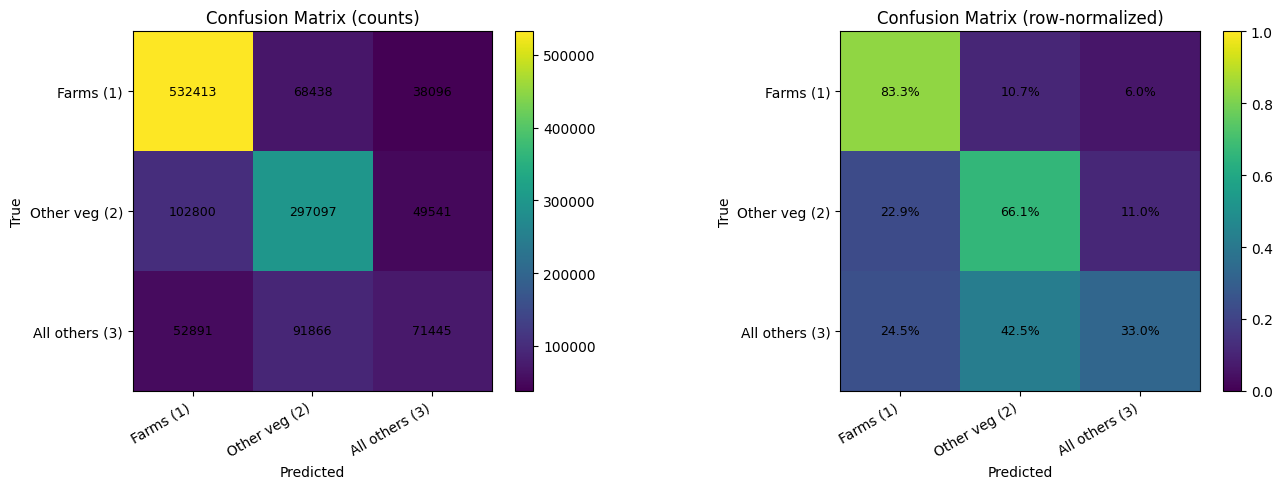

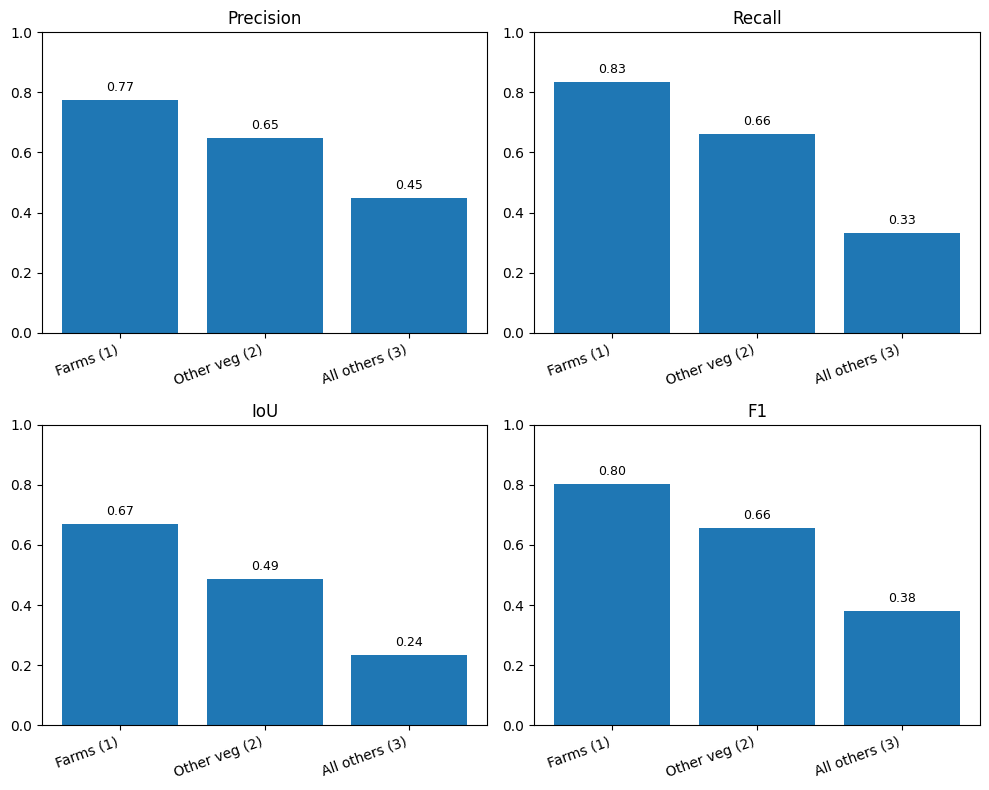

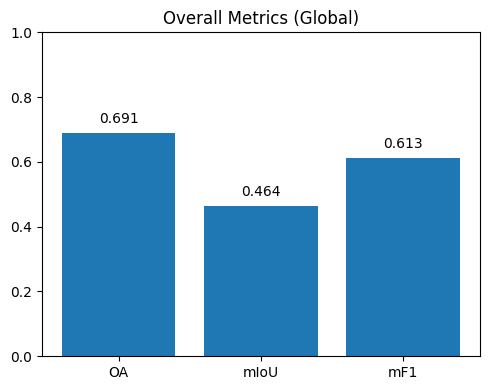

In [6]:
cm = metrics_cm
per = metrics_per_class
ov  = metrics_overall
class_names = per["class_names"]

# --- 1) Confusion matrix heatmap (counts + normalized) ---
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# counts
im0 = ax[0].imshow(cm, interpolation='nearest')
ax[0].set_title("Confusion Matrix (counts)")
ax[0].set_xlabel("Predicted"); ax[0].set_ylabel("True")
ax[0].set_xticks(range(len(class_names))); ax[0].set_yticks(range(len(class_names)))
ax[0].set_xticklabels(class_names, rotation=30, ha='right')
ax[0].set_yticklabels(class_names)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax[0].text(j, i, str(cm[i, j]), ha="center", va="center", fontsize=9)
fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

# row-normalized (%)
row_sums = cm.sum(axis=1, keepdims=True).astype(float)
norm = np.divide(cm, row_sums, out=np.zeros_like(cm, dtype=float), where=row_sums!=0)
im1 = ax[1].imshow(norm, interpolation='nearest', vmin=0.0, vmax=1.0)
ax[1].set_title("Confusion Matrix (row-normalized)")
ax[1].set_xlabel("Predicted"); ax[1].set_ylabel("True")
ax[1].set_xticks(range(len(class_names))); ax[1].set_yticks(range(len(class_names)))
ax[1].set_xticklabels(class_names, rotation=30, ha='right')
ax[1].set_yticklabels(class_names)
for i in range(norm.shape[0]):
    for j in range(norm.shape[1]):
        ax[1].text(j, i, f"{norm[i, j]*100:.1f}%", ha="center", va="center", fontsize=9)
fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# --- 2) Four bar plots: Precision, Recall, IoU, F1 ---
metrics_list = [("Precision", per["precision"]),
                ("Recall",    per["recall"]),
                ("IoU",       per["iou"]),
                ("F1",        per["f1"])]

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.ravel()
for k, (title, vals) in enumerate(metrics_list):
    axs[k].bar(range(len(class_names)), vals)
    axs[k].set_title(title)
    axs[k].set_ylim(0, 1)
    axs[k].set_xticks(range(len(class_names)))
    axs[k].set_xticklabels(class_names, rotation=20, ha='right')
    for i, v in enumerate(vals):
        axs[k].text(i, v + 0.02, f"{v:.2f}", ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

# --- 3) Overall metrics bar plot: OA, mIoU, mF1 ---
overall_names = ["OA", "mIoU", "mF1"]
overall_vals  = [ov["oa"], ov["mIoU"], ov["mF1"]]

plt.figure(figsize=(5,4))
plt.bar(range(len(overall_names)), overall_vals)
plt.xticks(range(len(overall_names)), overall_names)
plt.ylim(0, 1)
for i, v in enumerate(overall_vals):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center', va='bottom', fontsize=10)
plt.title("Overall Metrics (Global)")
plt.tight_layout()
plt.show()

## Exporting the model

In [7]:
# === Cell: Export trained model ===
export_dir = Path("./artifacts")  # change if you prefer another folder
export_dir.mkdir(parents=True, exist_ok=True)

use_ndvi = bool(CFG.get("use_ndvi", False))
in_channels = 4 if use_ndvi else 3

stamp = time.strftime("%Y%m%d-%H%M%S")
ckpt_name = f"unetflex_rgb{'ndvi' if use_ndvi else ''}_depth{CFG['unet_depth']}_base{CFG['base_filters']}_ps{PATCH_SIZE}_{stamp}.pt"
ckpt_path = export_dir / ckpt_name

checkpoint = {
    "model_state": model.state_dict(),   # weights
    "cfg": CFG,                          # full training config (for reconstruction)
    "meta": {
        "created": stamp,
        "torch": torch.__version__,
        "device": DEVICE,
        "in_channels": in_channels,
        "num_classes": NUM_CLASSES,
        "patch_size": PATCH_SIZE,
        "stride": STRIDE,
    },
}

torch.save(checkpoint, ckpt_path)
print(f"Saved checkpoint to: {ckpt_path}")

Saved checkpoint to: artifacts/unetflex_rgbndvi_depth5_base32_ps512_20251025-235331.pt


## Loading the Model

In [5]:
# Point to the file saved above
ckpt_path = Path("./artifacts/unetflex_rgbndvi_depth5_base32_ps512_20251025-235331.pt") # or set explicitly to the .pt you want

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
ckpt = torch.load(ckpt_path, map_location=DEVICE)

cfg_loaded = ckpt["cfg"]
use_ndvi_loaded = bool(cfg_loaded.get("use_ndvi", False))
in_ch_loaded = 4 if use_ndvi_loaded else 3
num_classes_loaded = int(cfg_loaded["num_classes"])

# Recreate the architecture exactly as trained
model = UNetFlex(
    in_ch=in_ch_loaded,
    n_classes=num_classes_loaded,
    base=cfg_loaded["base_filters"],
    depth=cfg_loaded["unet_depth"],
    use_bn=cfg_loaded["use_batchnorm"],
    p_drop=cfg_loaded["dropout_p"],
).to(DEVICE)

# Load weights
model.load_state_dict(ckpt["model_state"], strict=True)
model.eval()

print(f"Loaded model from: {ckpt_path}")
print(f"\n in_ch={in_ch_loaded}, \n num_classes={num_classes_loaded}, "
      f"\n depth={cfg_loaded['unet_depth']}, \n base={cfg_loaded['base_filters']}, "
      f"\n use_bn={cfg_loaded['use_batchnorm']}, \n dropout_p={cfg_loaded['dropout_p']}")

Loaded model from: artifacts/unetflex_rgbndvi_depth5_base32_ps512_20251025-235331.pt

 in_ch=4, 
 num_classes=3, 
 depth=5, 
 base=32, 
 use_bn=True, 
 dropout_p=0.0


# Final Prediction

## Predicting the Entire Image Set

In [6]:
# ---------------------------------------------------------------------
# ---------------------------- PATHS ----------------------------------
# ---------------------------------------------------------------------

train_rgb_dir  = Path("../data/train_rgb")
test_rgb_dir   = Path("../data/test_rgb")
train_ndvi_dir = Path("../data/train_ndvi")
test_ndvi_dir  = Path("../data/test_ndvi")

# Boundary vector (.gpkg/.geojson/.shp all OK)
boundary_path  = Path("../data/enschede_boundary/enschede_28992.gpkg")

# Output folders
artifacts_dir  = Path("../data/final_prediction")
tiles_out_dir  = artifacts_dir / "pred_tiles"
tiles_out_dir.mkdir(parents=True, exist_ok=True)
mosaic_path    = artifacts_dir / "pred_enschede_full.tif"
clipped_path   = artifacts_dir / "pred_enschede_full_clipped.tif"

# ---------------------------------------------------------------------
# ---------------------- CONFIG VARIABLES ------------------------------
# ---------------------------------------------------------------------
use_ndvi    = bool(CFG.get("use_ndvi", False))
PATCH_SIZE  = CFG["patch_size"]
STRIDE      = (CFG["patch_size"] // 2) if CFG["stride"] is None else CFG["stride"]
NUM_CLASSES = CFG["num_classes"]

# ---------------------------------------------------------------------
# -------------------------- HELPERS ----------------------------------
# ---------------------------------------------------------------------

def rgb_to_ndvi_name(rgb_name: str) -> str:
    """Convert RGB filename to NDVI filename based on naming pattern."""
    if "_RGB_" in rgb_name:
        return rgb_name.replace("_RGB_", "_CIR_")
    stem, ext = os.path.splitext(rgb_name)
    low = stem.lower()
    i = low.find("rgb")
    if i != -1:
        return stem[:i] + "CIR" + stem[i+3:] + ext
    return rgb_name.replace("RGB", "CIR").replace("rgb", "CIR")

def hann2d(h, w):
    """2D Hann window to blend overlaps smoothly."""
    wx = np.hanning(w)
    wy = np.hanning(h)
    if w == 1: wx = np.ones(1)
    if h == 1: wy = np.ones(1)
    win = np.outer(wy, wx).astype(np.float32)
    return np.clip(win, 1e-3, None)

def stack_full_tile(rgb_src, ndvi_reader=None):
    """Read full RGB(+NDVI) tile as float32 HW*C array."""
    rgb = rgb_src.read([1,2,3], out_dtype=np.uint16).astype(np.float32)
    if ndvi_reader is not None:
        ndvi_ma = ndvi_reader.read(1, masked=True).astype(np.float32)
        ndvi = np.clip(ndvi_ma.filled(np.nan), -1.0, 1.0)[np.newaxis]
        arr = np.concatenate([rgb, ndvi], axis=0)
    else:
        arr = rgb
    hwc = np.transpose(arr, (1,2,0))
    return hwc

def tilewise_norm(img_hwc):
    """Normalize full tile per band (mean/std ignoring NaN)."""
    mean = np.nanmean(img_hwc, axis=(0,1))
    std  = np.nanstd(img_hwc, axis=(0,1)) + 1e-6
    out = (img_hwc - mean) / std
    out[~np.isfinite(out)] = 0.0
    return out

# ---------------------------------------------------------------------
# ---------------------- TILE PREDICTION -------------------------------
# ---------------------------------------------------------------------

@torch.no_grad()
def predict_tile(rgb_path, ndvi_path):
    with rasterio.open(rgb_path) as rgb_src:
        H, W = rgb_src.height, rgb_src.width

        # NDVI alignment if used
        if use_ndvi:
            with rasterio.open(ndvi_path) as ndvi_src:
                need_vrt = (
                    ndvi_src.crs != rgb_src.crs or
                    ndvi_src.transform != rgb_src.transform or
                    ndvi_src.width != rgb_src.width or
                    ndvi_src.height != rgb_src.height
                )
                ndvi_reader = WarpedVRT(
                    ndvi_src,
                    crs=rgb_src.crs,
                    transform=rgb_src.transform,
                    width=rgb_src.width,
                    height=rgb_src.height,
                    resampling=Resampling.bilinear,
                ) if need_vrt else ndvi_src

                full_hwc = stack_full_tile(rgb_src, ndvi_reader)
                if isinstance(ndvi_reader, WarpedVRT):
                    ndvi_reader.close()
        else:
            full_hwc = stack_full_tile(rgb_src, None)

        full_hwc_norm = tilewise_norm(full_hwc)

        prob_acc = np.zeros((NUM_CLASSES, H, W), dtype=np.float32)
        wt_acc   = np.zeros((H, W), dtype=np.float32)
        win2d    = hann2d(PATCH_SIZE, PATCH_SIZE)

        for win in iter_windows_full(H, W, PATCH_SIZE, STRIDE):
            r0, c0, h, w = int(win.row_off), int(win.col_off), int(win.height), int(win.width)
            patch_hwc = full_hwc_norm[r0:r0+h, c0:c0+w, :]

            # Pad edge patches if smaller than PATCH_SIZE
            if patch_hwc.shape[0] != PATCH_SIZE or patch_hwc.shape[1] != PATCH_SIZE:
                pad_h = PATCH_SIZE - patch_hwc.shape[0]
                pad_w = PATCH_SIZE - patch_hwc.shape[1]
                patch_hwc = np.pad(patch_hwc, ((0,pad_h),(0,pad_w),(0,0)), mode='constant')

            x_chw = np.transpose(patch_hwc, (2,0,1)).astype(np.float32)
            x = torch.from_numpy(x_chw).unsqueeze(0).to(DEVICE)

            with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda" and CFG["use_amp"])):
                logits = model(x)
                probs  = torch.softmax(logits, dim=1).squeeze(0).cpu().numpy()

            probs = probs[:, :h, :w]
            w_crop = win2d[:h, :w]
            prob_acc[:, r0:r0+h, c0:c0+w] += probs * w_crop[np.newaxis, ...]
            wt_acc[r0:r0+h, c0:c0+w]      += w_crop

        wt_acc[wt_acc == 0] = 1.0
        prob_acc /= wt_acc[np.newaxis, ...]
        pred = np.argmax(prob_acc, axis=0).astype(np.uint8) + 1  # class 1..C

        profile = rgb_src.profile.copy()
        profile.update(
            crs=rgb_src.crs,
            transform=rgb_src.transform,
            width=rgb_src.width,
            height=rgb_src.height,
            count=1,
            dtype="uint8",
            compress="lzw",
            tiled=True,
            blockxsize=256,
            blockysize=256,
            nodata=0,
        )
        return pred, profile

# ---------------------------------------------------------------------
# ---------------------- PREDICT ALL TILES -----------------------------
# ---------------------------------------------------------------------

rgb_index, ndvi_index = {}, {}
for d in [train_rgb_dir, test_rgb_dir]:
    if d.exists():
        for f in os.listdir(d):
            if f.lower().endswith(".tif"):
                rgb_index[f] = d / f

if use_ndvi:
    for d in [train_ndvi_dir, test_ndvi_dir]:
        if d.exists():
            for f in os.listdir(d):
                if f.lower().endswith(".tif"):
                    ndvi_index[f] = d / f

all_rgb_fnames = sorted(rgb_index.keys())
print(f"Total RGB tiles to predict: {len(all_rgb_fnames)}")

written_tiles = []
for i, rgb_name in enumerate(all_rgb_fnames, start=1):
    rgb_path = rgb_index[rgb_name]
    ndvi_path = None
    if use_ndvi:
        ndvi_name = rgb_to_ndvi_name(rgb_name)
        ndvi_path = ndvi_index.get(ndvi_name)
        if ndvi_path is None:
            print(f"[WARN] Missing NDVI for {rgb_name} -> {ndvi_name}, skipping.")
            continue

    print(f"[{i}/{len(all_rgb_fnames)}] Predicting {rgb_name}")
    pred, profile = predict_tile(rgb_path, ndvi_path)

    out_tif = tiles_out_dir / rgb_name.replace(".tif", "_pred.tif")
    with rasterio.open(out_tif, "w", **profile) as dst:
        dst.write(pred, 1)
        dst.build_overviews([2,4,8,16], Resampling.nearest)
        dst.update_tags(ns='rio_overview', resampling='nearest')

    written_tiles.append(out_tif)

print(f"Wrote {len(written_tiles)} prediction tiles to {tiles_out_dir}")

Total RGB tiles to predict: 20
[1/20] Predicting 2025_246000_470000_RGB_lrl.tif
[2/20] Predicting 2025_246000_474000_RGB_lrl.tif
[3/20] Predicting 2025_250000_466000_RGB_lrl.tif
[4/20] Predicting 2025_250000_470000_RGB_lrl.tif
[5/20] Predicting 2025_250000_474000_RGB_lrl.tif
[6/20] Predicting 2025_250000_478000_RGB_lrl.tif
[7/20] Predicting 2025_254000_466000_RGB_lrl.tif
[8/20] Predicting 2025_254000_470000_RGB_lrl.tif
[9/20] Predicting 2025_254000_474000_RGB_lrl.tif
[10/20] Predicting 2025_254000_478000_RGB_lrl.tif
[11/20] Predicting 2025_254000_482000_RGB_lrl.tif
[12/20] Predicting 2025_258000_466000_RGB_lrl.tif
[13/20] Predicting 2025_258000_470000_RGB_lrl.tif
[14/20] Predicting 2025_258000_474000_RGB_lrl.tif
[15/20] Predicting 2025_258000_478000_RGB_lrl.tif
[16/20] Predicting 2025_258000_482000_RGB_lrl.tif
[17/20] Predicting 2025_262000_470000_RGB_lrl.tif
[18/20] Predicting 2025_262000_474000_RGB_lrl.tif
[19/20] Predicting 2025_262000_478000_RGB_lrl.tif
[20/20] Predicting 2025_2620

## Visualising Prediction Results

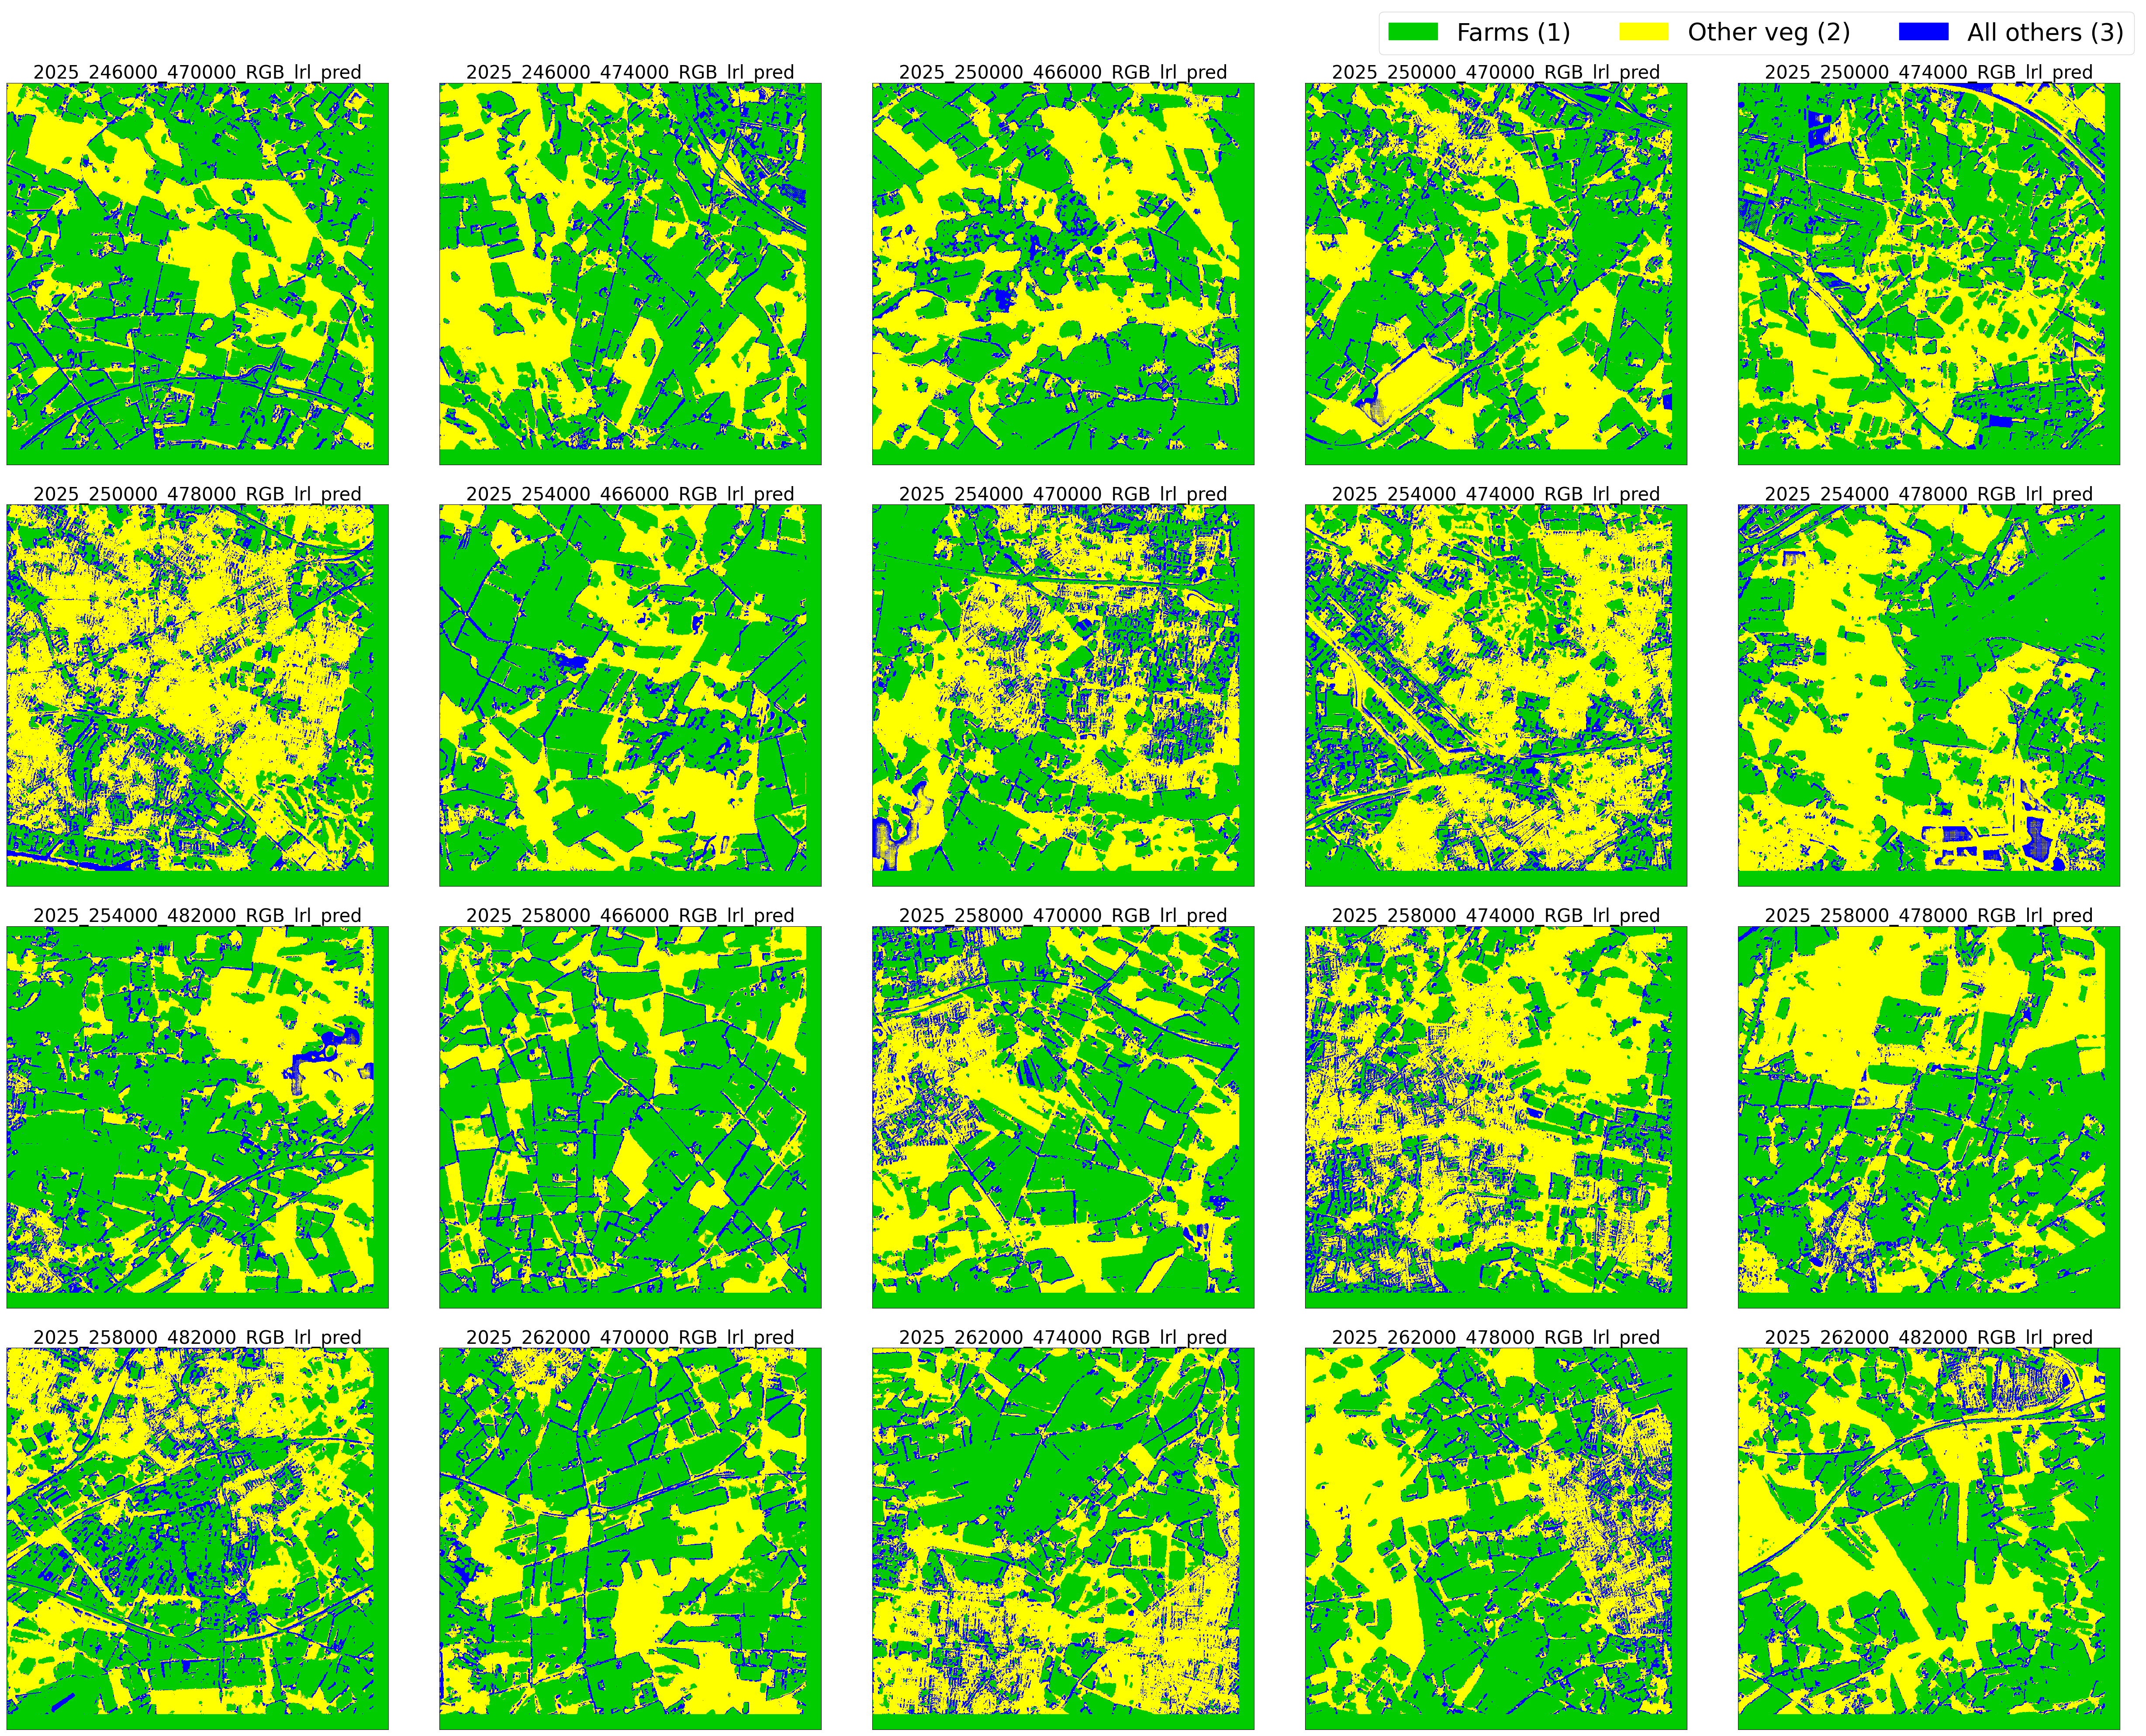

In [46]:
# ===============================
# SETTINGS
# ===============================
pred_folder = Path("../data/final_prediction/pred_tiles")  # folder with predicted GeoTIFFs
tif_files = sorted(pred_folder.glob("*.tif"))

# Define class colors
colors = [
    (0, 0, 0, 0),      # 0 = transparent nodata
    (0, 0.8, 0, 1),    # 1 = green (Farms)
    (1, 1, 0, 1),      # 2 = yellow (Other veg)
    (0, 0, 1, 1),      # 3 = blue (All others)
]
cmap = ListedColormap(colors)
norm = BoundaryNorm([0, 1, 2, 3, 4], cmap.N)

# Class labels
class_labels = {1: "Farms (1)", 2: "Other veg (2)", 3: "All others (3)"}

# ===============================
# PLOT ALL TILES (7x3 grid)
# ===============================
n_tiles = len(tif_files)
if n_tiles == 0:
    raise ValueError(f"No .tif files found in {pred_folder}")

nrows, ncols = 4, 5  # fixed grid
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10*ncols, 10*nrows))
axes = np.array(axes).reshape(-1)  # flatten for simple indexing

for ax, tif_path in zip(axes, tif_files):
    with rasterio.open(tif_path) as src:
        data = src.read(1)
        extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)

    disp = np.ma.masked_where(data == 0, data)
    im = ax.imshow(disp, cmap=cmap, norm=norm, interpolation="nearest", extent=extent)
    ax.set_title(tif_path.stem, fontsize=30)
    ax.set_xticks([])
    ax.set_yticks([])

# Hide any unused subplot slots
if len(axes) > n_tiles:
    for ax in axes[len(tif_files):]:
        ax.axis("off")

# Explicitly hide the 21st subplot if it exists
if len(axes) >= 21:
    axes[20].axis("off")

# Legend (only once)
handles = [mpatches.Patch(color=colors[val], label=name) for val, name in class_labels.items()]
fig.legend(handles=handles, loc="upper right", ncol=3, frameon=True, fontsize=40)

plt.suptitle(" ", y = 1.0)
plt.tight_layout()
plt.show()

## Per-Tile Class Distribution

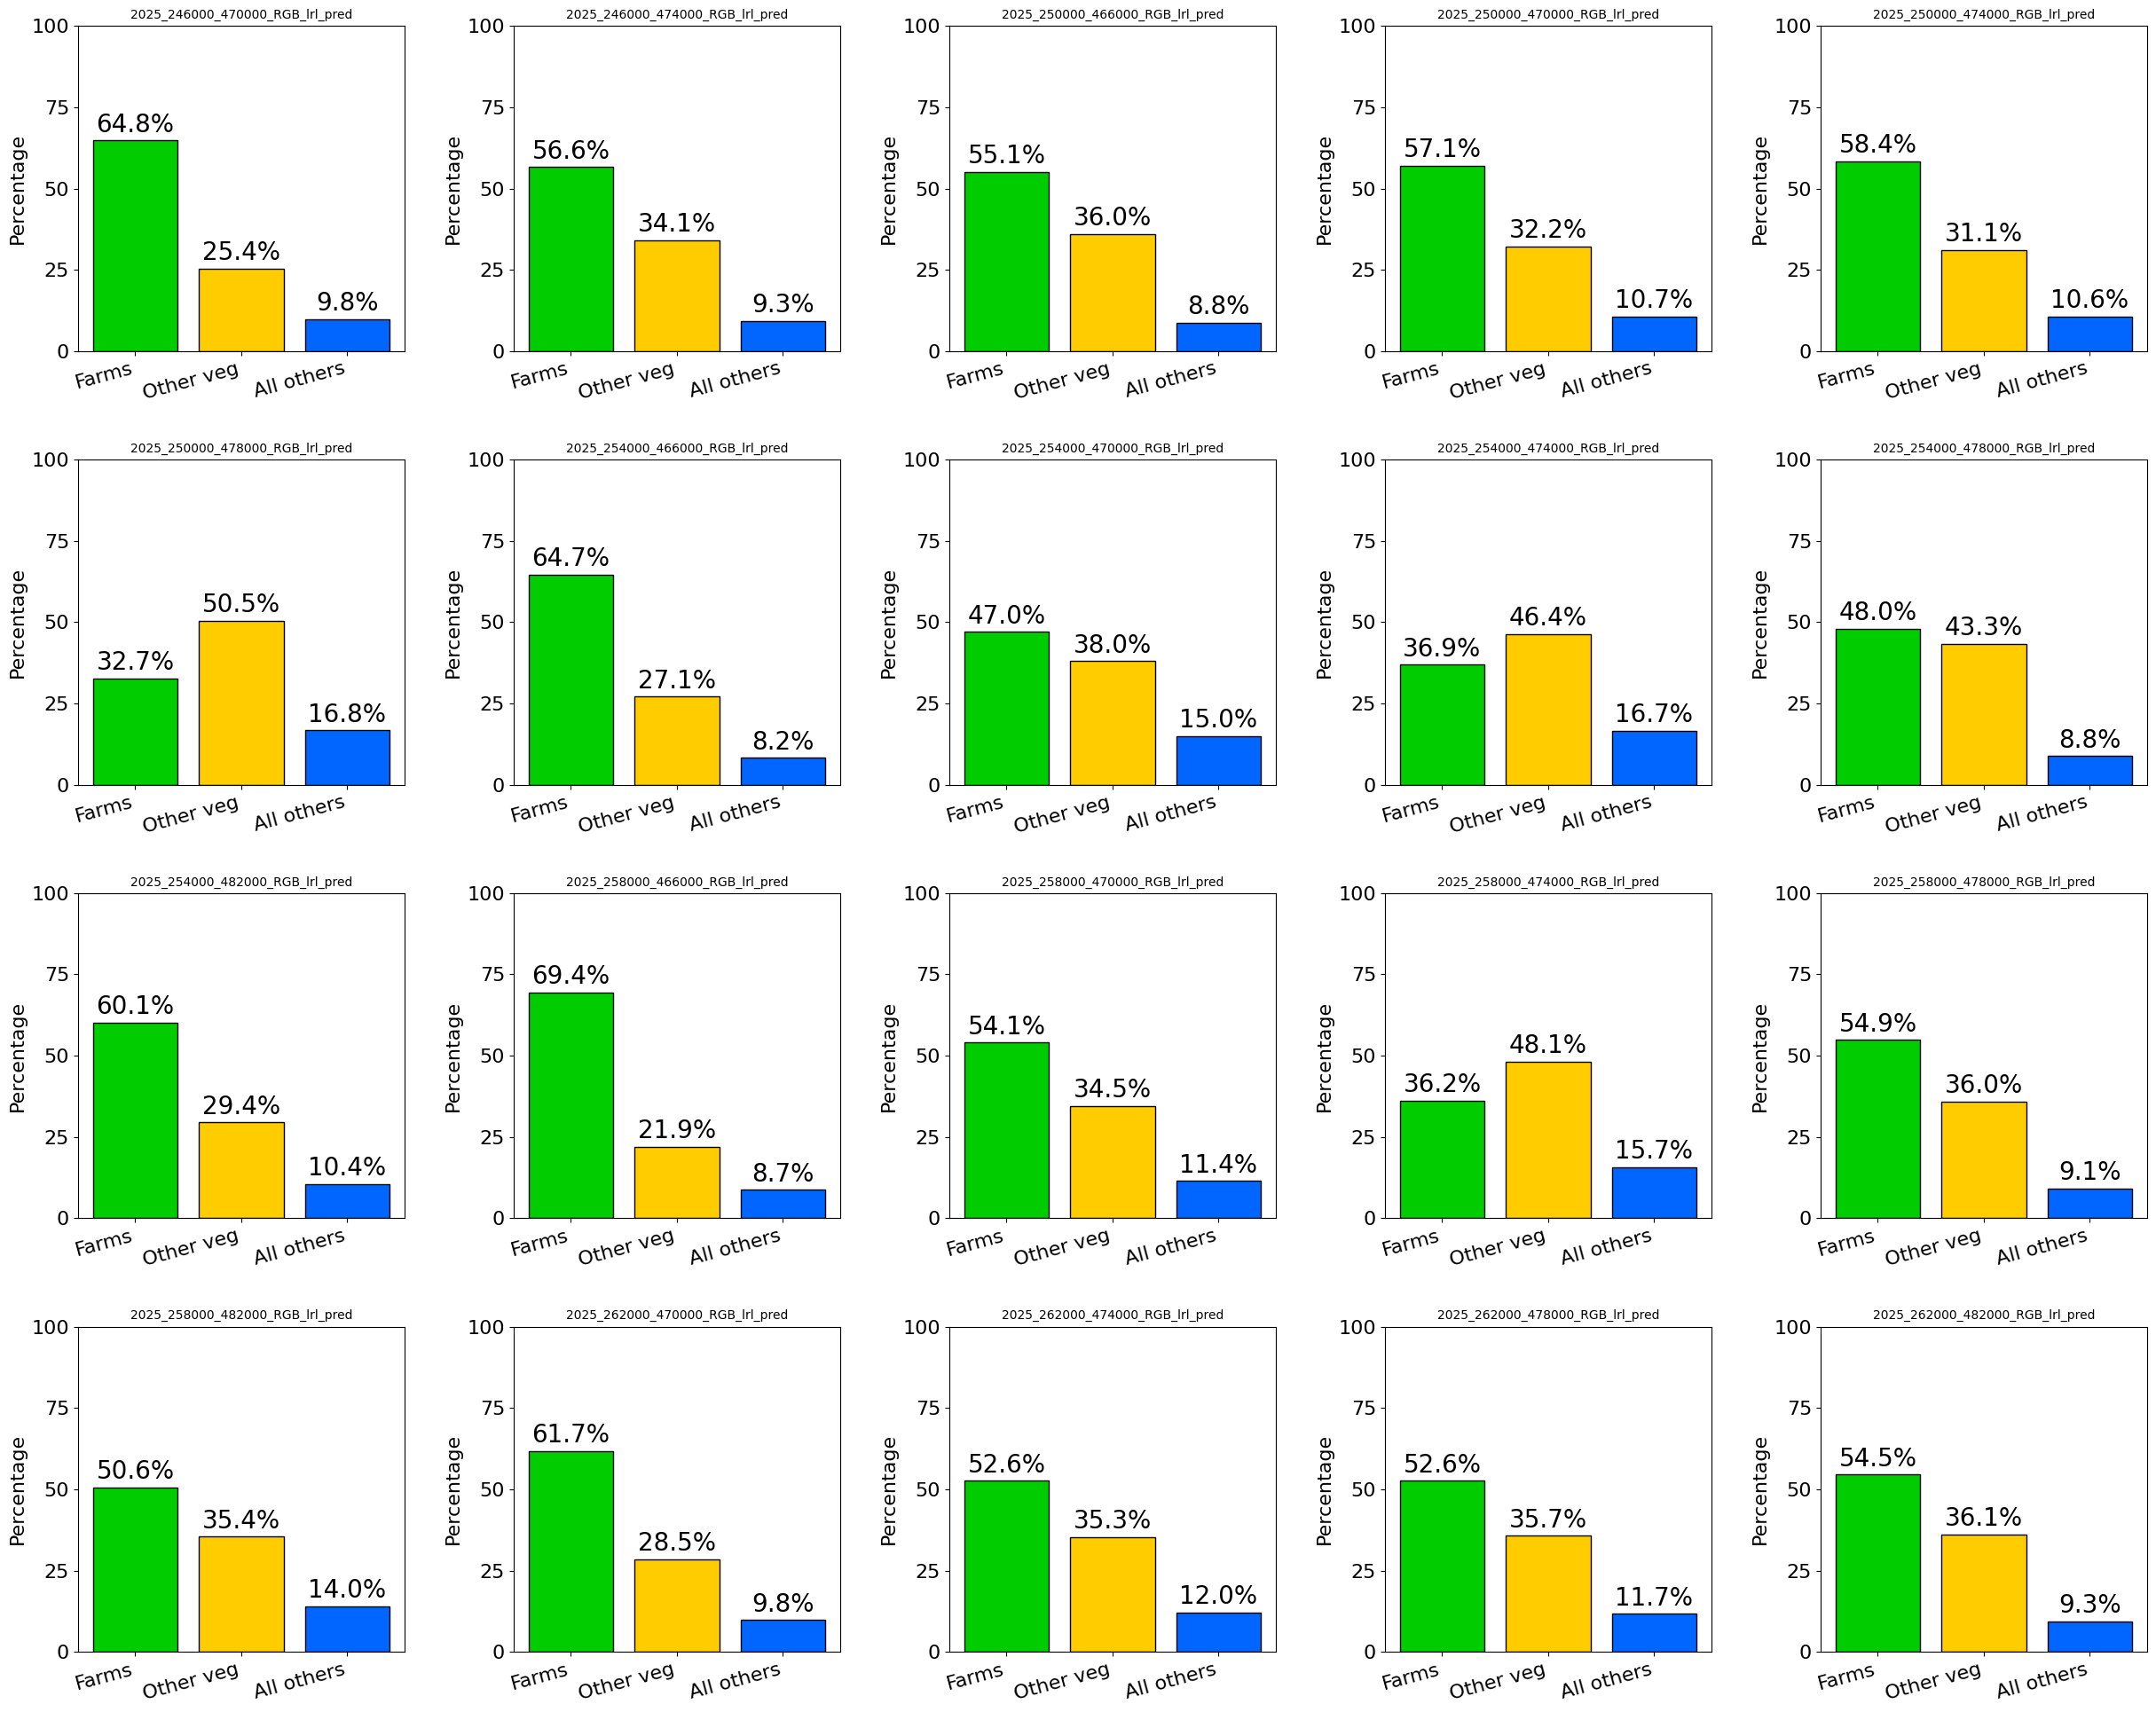

In [37]:
# ===============================
# SETTINGS
# ===============================
pred_folder = Path("../data/final_prediction/pred_tiles")  # folder with predicted GeoTIFFs
tif_files = sorted(pred_folder.glob("*.tif"))

# Class labels & colors (0 is nodata/ignored)
class_labels = {1: "Farms", 2: "Other veg", 3: "All others"}
class_colors = {1: "#00cc00", 2: "#ffcc00", 3: "#0066ff"}
valid_classes = {0, 1, 2, 3}

nrows, ncols = 4, 5  # fixed grid for 20 tiles (21st will be hidden)

# ===============================
# HELPERS
# ===============================
def clean_label_band(data, nodata):
    """Map any value not in {0,1,2,3} to 0 (nodata). Handle nodata and floats."""
    a = data.copy()

    # handle nodata
    if nodata is not None:
        if np.isnan(nodata):
            a[~np.isfinite(a)] = 0
        else:
            a[a == nodata] = 0

    # if float (e.g., from earlier processing), round
    if np.issubdtype(a.dtype, np.floating):
        a = np.rint(a)

    # clamp invalid classes to 0
    a[~np.isin(a, list(valid_classes))] = 0
    return a.astype(np.int32, copy=False)

# ===============================
# PREP FIGURE
# ===============================
n_tiles = len(tif_files)
if n_tiles == 0:
    raise ValueError(f"No .tif files found in {pred_folder}")

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 5*nrows))
axes = np.array(axes).reshape(-1)

# ===============================
# PER-TILE CLASS DISTRIBUTION (%)
# ===============================
for ax, tif_path in zip(axes, tif_files):
    with rasterio.open(tif_path) as src:
        band = src.read(1)
        band = clean_label_band(band, src.nodata)

    # count classes (drop nodata=0)
    vals, counts = np.unique(band, return_counts=True)
    counts_map = {int(v): int(c) for v, c in zip(vals, counts)}
    counts_map.pop(0, None)

    total = sum(counts_map.values())
    # ensure stable order [1,2,3], even if some classes absent
    classes = [1, 2, 3]
    perc = [(100 * counts_map.get(c, 0) / total) if total > 0 else 0.0 for c in classes]

    # plot bar chart for this tile
    x = np.arange(len(classes))
    bars = ax.bar(
        x, perc, color=[class_colors[c] for c in classes], edgecolor="black", width=0.8
    )

    # labels
    ax.set_title(tif_path.stem, fontsize=10)
    ax.set_xticks(x)
    ax.set_xticklabels([class_labels[c] for c in classes], rotation=15, ha="right", fontsize=20)
    ax.set_ylim(0, 100)
    ax.set_yticks([0, 25, 50, 75, 100])
    ax.set_ylabel("Percentage", fontsize=16)
    ax.tick_params(axis='both', labelsize=16)
    

    # annotate percentages
    for b, v in zip(bars, perc):
        ax.text(b.get_x() + b.get_width()/2, v + 1, f"{v:.1f}%", ha="center", va="bottom", fontsize=20)

# Hide any unused subplot slots
if len(axes) > n_tiles:
    for ax in axes[n_tiles:]:
        ax.axis("off")

# Single legend (classes)
#handles = [plt.matplotlib.patches.Patch(color=class_colors[c], label=class_labels[c]) for c in [1,2,3]]
#fig.legend(handles=handles, loc="upper right", frameon=True)

#plt.suptitle("Per-Tile Class Distribution (in %) - Predicted Tiles", fontsize=16, y=1.00)
plt.tight_layout()
plt.show()

In [47]:
# =====================================================
# CELL 1: PRINT PER-TILE CLASS DISTRIBUTION (PERCENTAGES)
# =====================================================
print("\n--- Per-Tile Class Distribution (percentages) ---")
tile_percentages = {}

for tif_path in tif_files:
    with rasterio.open(tif_path) as src:
        band = src.read(1)
        band = clean_label_band(band, src.nodata)

    vals, counts = np.unique(band, return_counts=True)
    counts_map = {int(v): int(c) for v, c in zip(vals, counts)}
    counts_map.pop(0, None)
    total = sum(counts_map.values())
    perc = {c: (100 * counts_map.get(c, 0) / total) if total > 0 else 0.0 for c in [1,2,3]}

    tile_percentages[tif_path.stem] = perc
    print(f"{tif_path.stem:<25}  Farms={perc[1]:6.2f}%   Other veg={perc[2]:6.2f}%   All others={perc[3]:6.2f}%")


--- Per-Tile Class Distribution (percentages) ---
2025_246000_470000_RGB_lrl_pred  Farms= 64.81%   Other veg= 25.41%   All others=  9.78%
2025_246000_474000_RGB_lrl_pred  Farms= 56.65%   Other veg= 34.10%   All others=  9.25%
2025_250000_466000_RGB_lrl_pred  Farms= 55.15%   Other veg= 36.02%   All others=  8.83%
2025_250000_470000_RGB_lrl_pred  Farms= 57.10%   Other veg= 32.25%   All others= 10.65%
2025_250000_474000_RGB_lrl_pred  Farms= 58.36%   Other veg= 31.06%   All others= 10.58%
2025_250000_478000_RGB_lrl_pred  Farms= 32.73%   Other veg= 50.50%   All others= 16.77%
2025_254000_466000_RGB_lrl_pred  Farms= 64.66%   Other veg= 27.11%   All others=  8.23%
2025_254000_470000_RGB_lrl_pred  Farms= 47.02%   Other veg= 37.99%   All others= 14.99%
2025_254000_474000_RGB_lrl_pred  Farms= 36.91%   Other veg= 46.41%   All others= 16.68%
2025_254000_478000_RGB_lrl_pred  Farms= 47.97%   Other veg= 43.25%   All others=  8.77%
2025_254000_482000_RGB_lrl_pred  Farms= 60.13%   Other veg= 29.44%   

## Overall Class Distribution

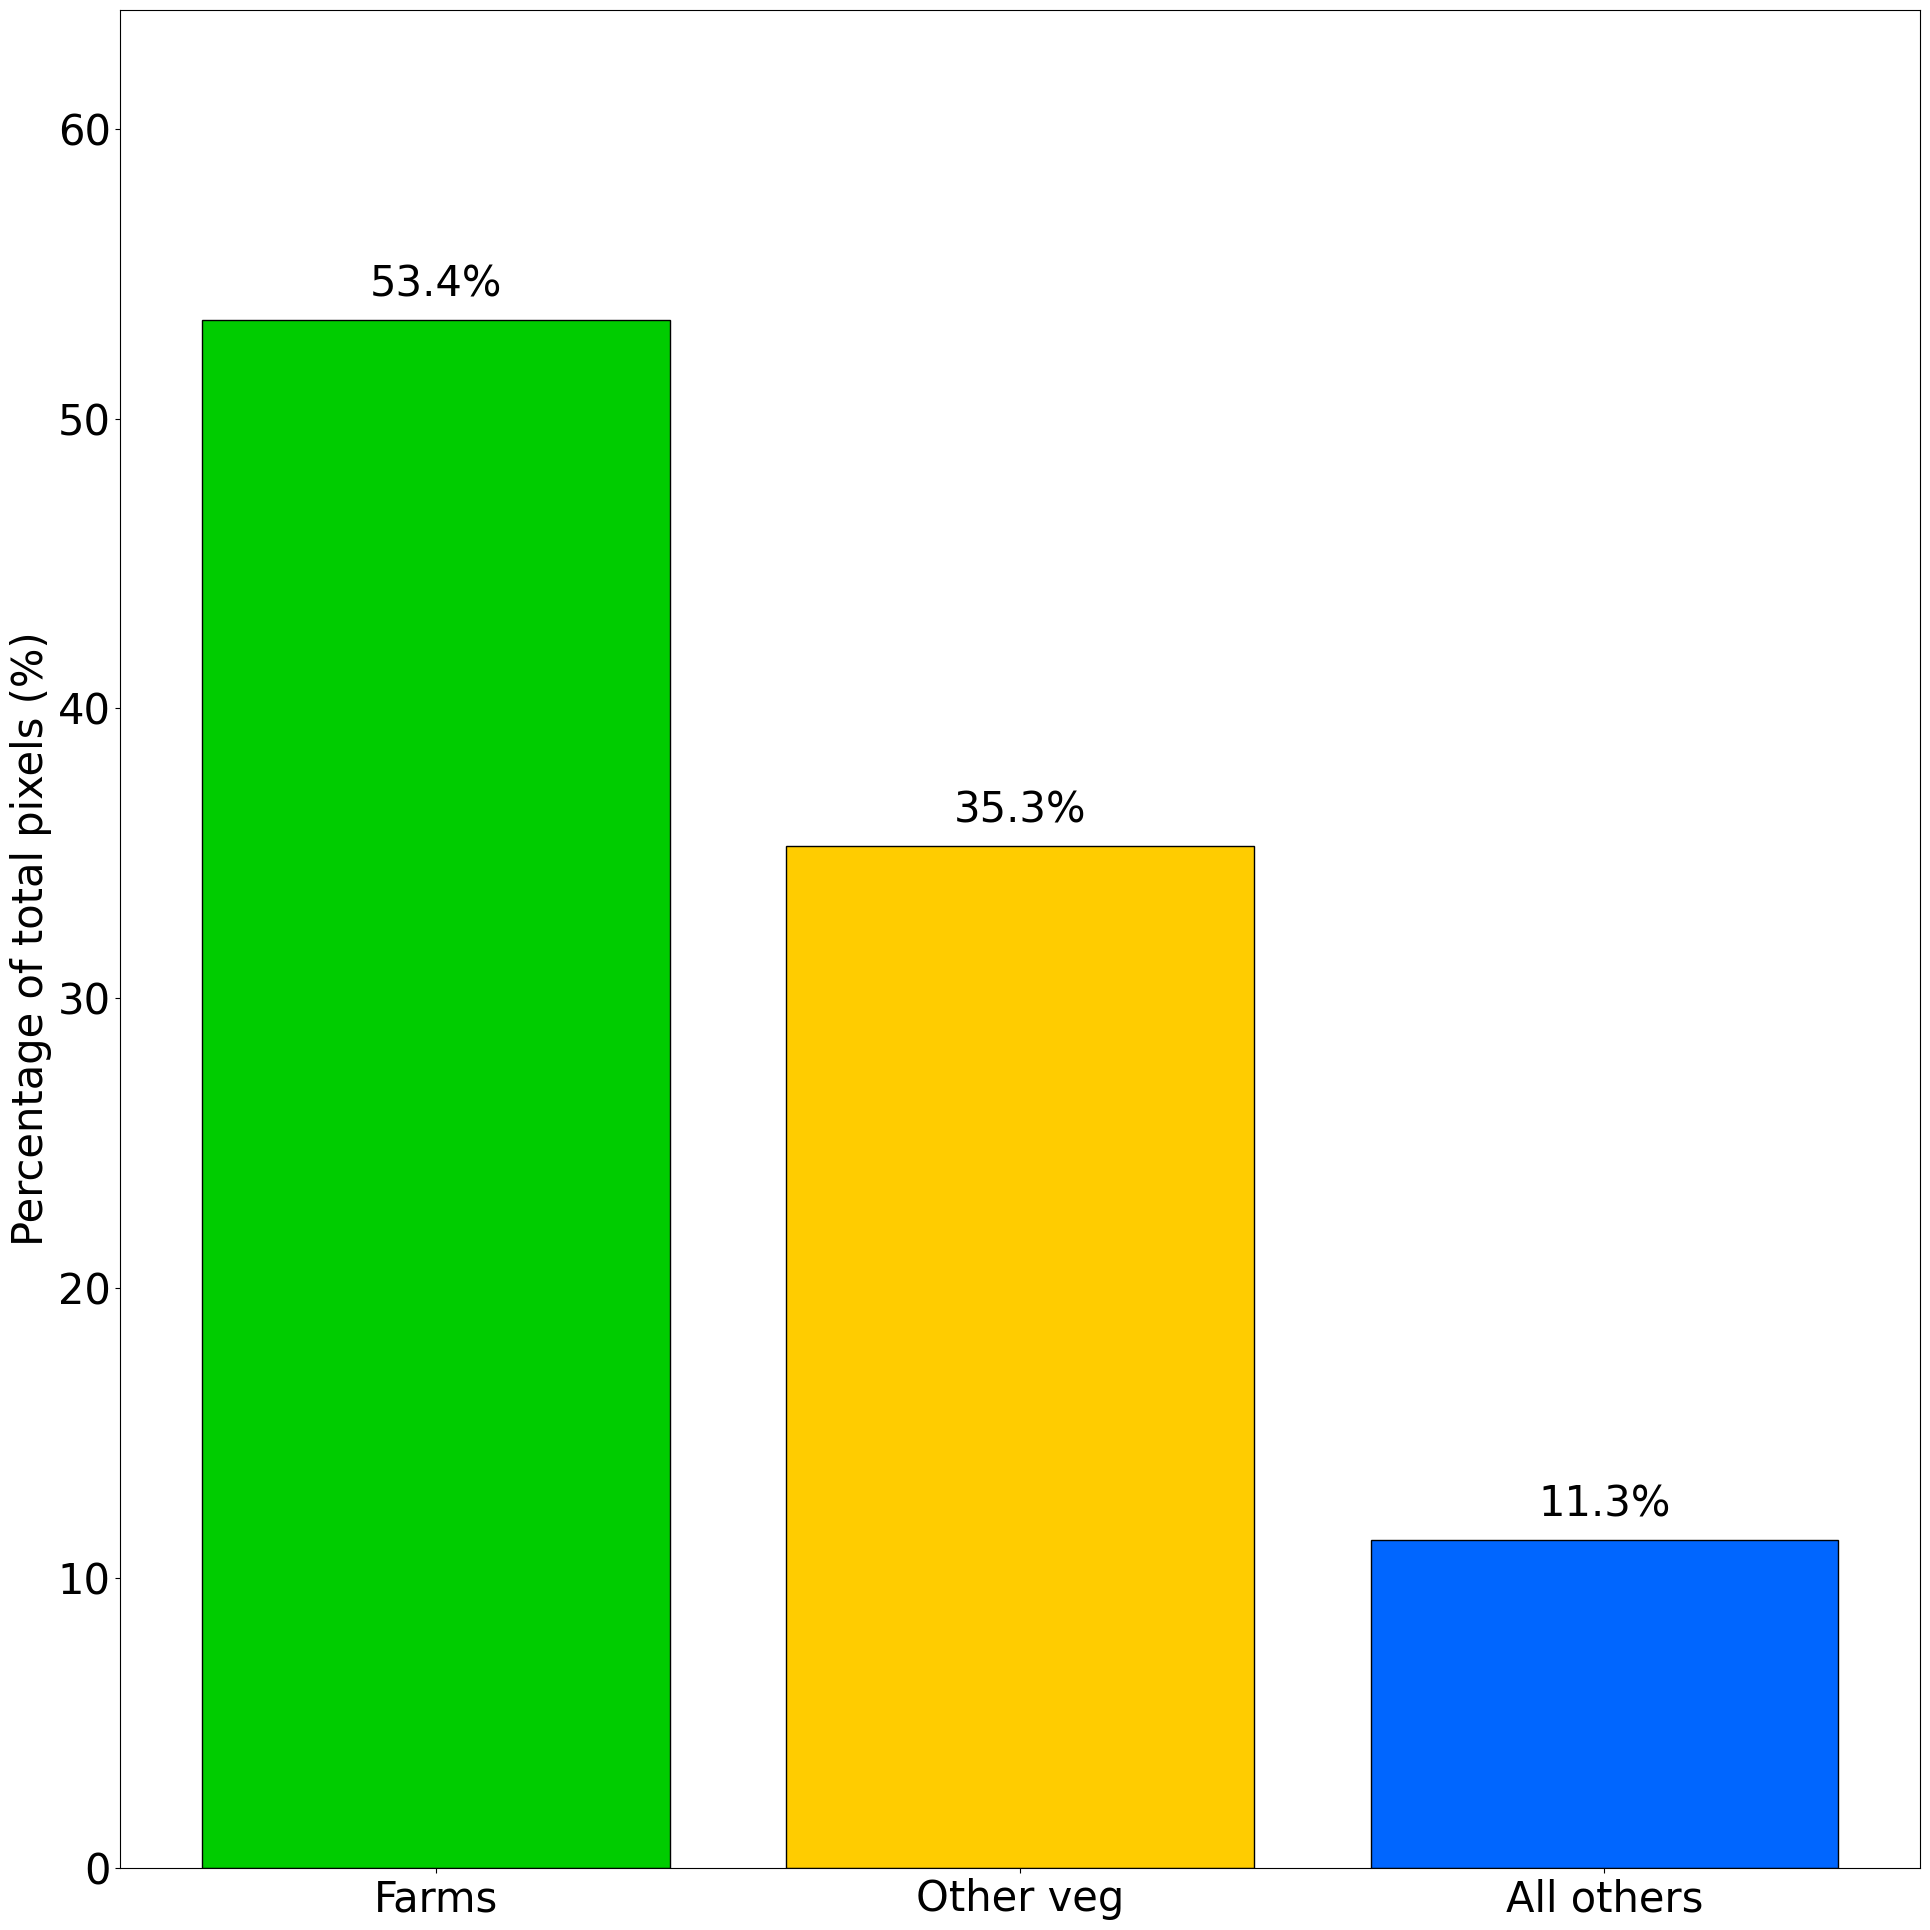

In [52]:
# ===============================
# SETTINGS
# ===============================
pred_folder = Path("../data/final_prediction/pred_tiles")
tif_files = sorted(pred_folder.glob("*.tif"))

class_labels = {
    1: "Farms",
    2: "Other veg",
    3: "All others"
}
class_colors = {
    1: "#00cc00",   # green
    2: "#ffcc00",   # yellow
    3: "#0066ff"    # blue
}

# ===============================
# COMPUTE OVERALL CLASS COUNTS
# ===============================
overall_counts = Counter()

for tif_path in tif_files:
    with rasterio.open(tif_path) as src:
        data = src.read(1)
        vals, counts = np.unique(data, return_counts=True)
        for v, c in zip(vals, counts):
            overall_counts[v] += c

# Remove nodata (0)
overall_counts.pop(0, None)

# Normalise to percentages
total_pixels = sum(overall_counts.values())
classes = sorted(overall_counts.keys())
counts = [overall_counts[c] for c in classes]
percents = [100 * overall_counts[c] / total_pixels for c in classes]

# ===============================
# PLOT BAR CHART
# ===============================
fig, ax = plt.subplots(figsize=(20, 20))

bars = ax.bar(
    [class_labels[c] for c in classes],
    percents,
    color=[class_colors[c] for c in classes],
    edgecolor="black"
)

# Add labels on top of bars
for bar, pct in zip(bars, percents):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.5,
        f"{pct:.1f}%",
        ha="center", va="bottom", fontsize=30
    )

ax.set_ylabel("Percentage of total pixels (%)", fontsize=30)
ax.set_ylim(0, max(percents) * 1.2)
plt.tight_layout()
plt.show()

## Comparing Prediction and Ground Truth

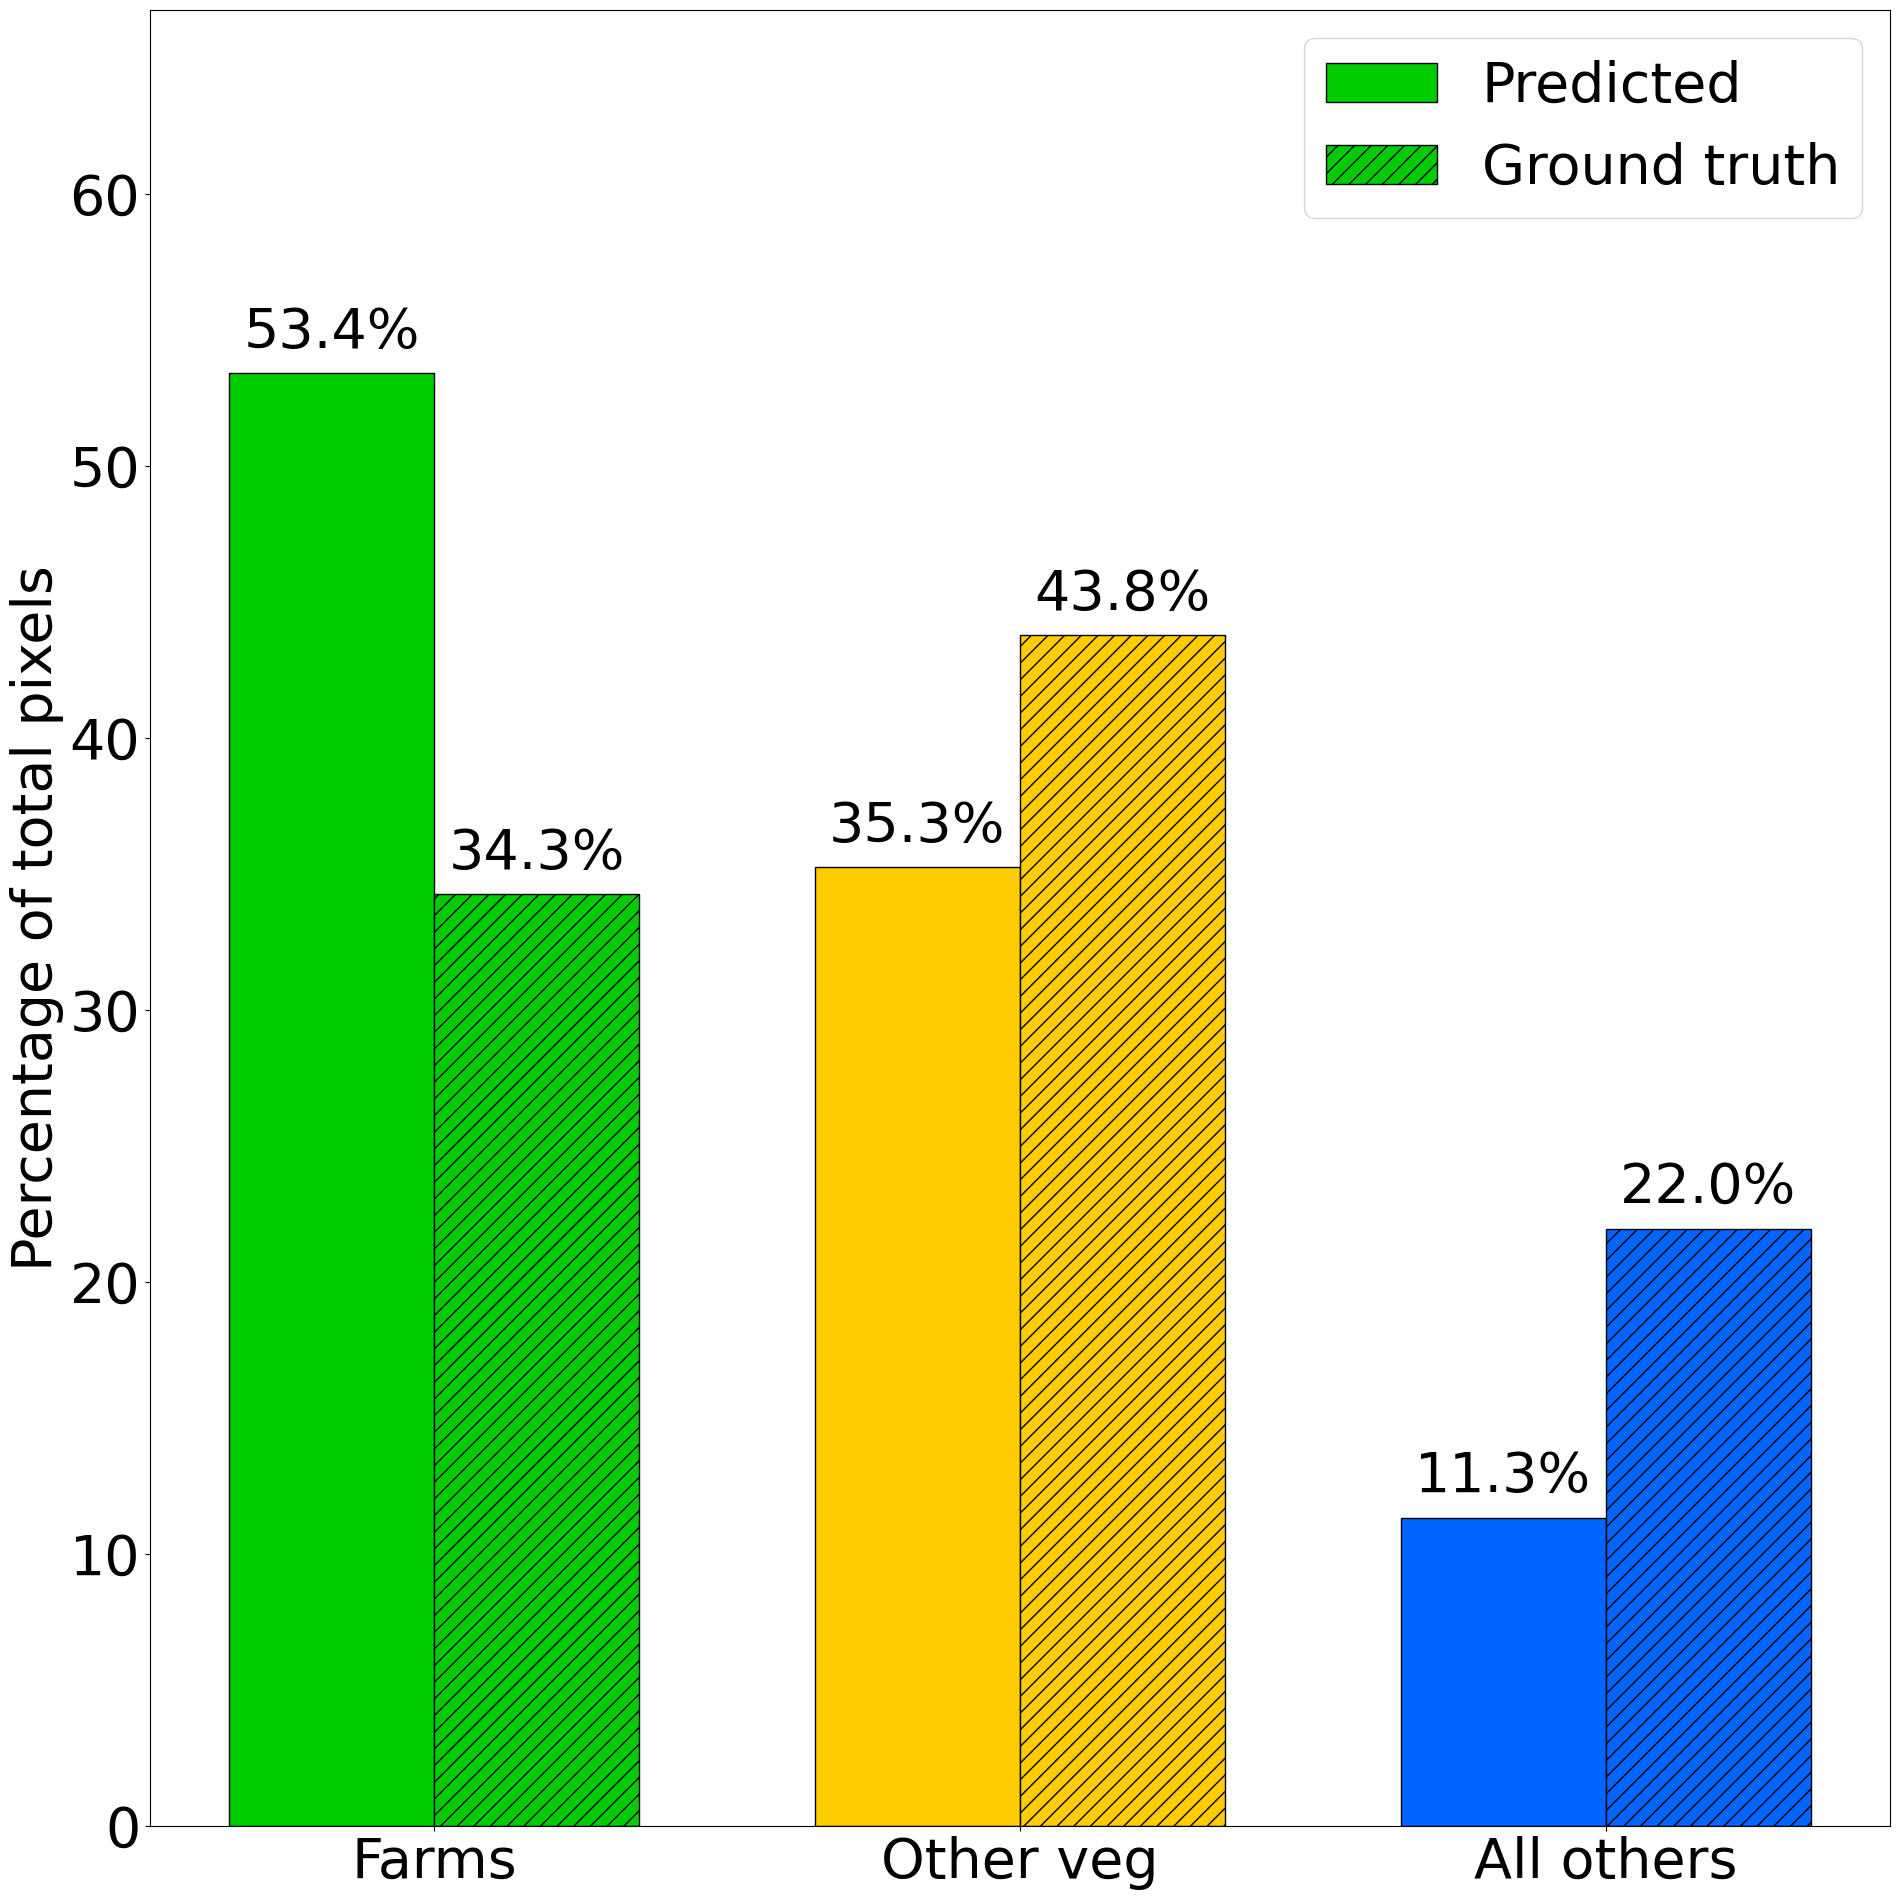

In [62]:
# ===============================
# SETTINGS
# ===============================

plt.rcParams.update({'font.size': 40})

pred_folder = Path("../data/final_prediction/pred_tiles")
train_gt_folder = Path("../data/lulc_tiles_train")
test_gt_folder  = Path("../data/lulc_tiles_test")

class_labels = {
    1: "Farms",
    2: "Other veg",
    3: "All others"
}
class_colors = {
    1: "#00cc00",   # green
    2: "#ffcc00",   # yellow
    3: "#0066ff"    # blue
}
valid_classes = {0, 1, 2, 3}  # 0 = nodata/ignore

# ===============================
# HELPERS
# ===============================
def clean_label_band(data, nodata):
    """
    Map anything not in {0,1,2,3} to 0 (nodata).
    Handle nodata (including NaN) and cast to int.
    """
    data = data.copy()

    # Handle nodata
    if nodata is not None:
        if np.isnan(nodata):
            mask = ~np.isfinite(data)
        else:
            mask = (data == nodata)
        data[mask] = 0

    # If the band is float (e.g., after some processing), round safely
    if np.issubdtype(data.dtype, np.floating):
        data = np.rint(data)

    # Clamp invalid labels to 0
    invalid = ~np.isin(data, list(valid_classes))
    data[invalid] = 0

    return data.astype(np.int32, copy=False)

def compute_class_distribution(folder_paths):
    counts_total = Counter()
    for folder in folder_paths:
        for tif_path in sorted(folder.glob("*.tif")):
            with rasterio.open(tif_path) as src:
                band = src.read(1)
                band = clean_label_band(band, src.nodata)

                vals, counts = np.unique(band, return_counts=True)
                for v, c in zip(vals, counts):
                    counts_total[int(v)] += int(c)

    # Remove nodata (0)
    counts_total.pop(0, None)
    total = sum(counts_total.values())
    return counts_total, total

# ===============================
# COMPUTE DISTRIBUTIONS
# ===============================
# Predicted
pred_counts, pred_total = compute_class_distribution([pred_folder])
# Ground truth (train + test)
gt_counts, gt_total = compute_class_distribution([train_gt_folder, test_gt_folder])

# Combine classes (ensure 1..3 in order even if some are missing)
classes = [c for c in (1,2,3) if (pred_counts.get(c,0)+gt_counts.get(c,0)) > 0]
if not classes:
    raise ValueError("No valid class pixels found in predicted or ground-truth tiles.")

pred_perc = [ (100 * pred_counts.get(c, 0) / pred_total) if pred_total>0 else 0.0 for c in classes ]
gt_perc   = [ (100 * gt_counts.get(c, 0) / gt_total)   if gt_total>0   else 0.0 for c in classes ]

# ===============================
# DOUBLE BAR PLOT
# ===============================
fig, ax = plt.subplots(figsize=(20, 20))
x = np.arange(len(classes))
width = 0.35

bars_pred = ax.bar(
    x - width/2, pred_perc, width,
    color=[class_colors[c] for c in classes],
    edgecolor="black", label="Predicted"
)
bars_gt = ax.bar(
    x + width/2, gt_perc, width,
    color=[class_colors[c] for c in classes],
    edgecolor="black", hatch="//", label="Ground truth"
)

# Add labels above bars
for bars, vals in [(bars_pred, pred_perc), (bars_gt, gt_perc)]:
    for bar, val in zip(bars, vals):
        ax.text(
            bar.get_x() + bar.get_width()/2,
            val + 0.5,
            f"{val:.1f}%",
            ha="center", va="bottom"
        )

ax.set_xticks(x)
ax.set_xticklabels([class_labels[c] for c in classes])
ax.set_ylabel("Percentage of total pixels")
ax.legend()
ax.set_ylim(0, max(max(pred_perc or [0]), max(gt_perc or [0])) * 1.25 + 1e-6)
plt.tight_layout()
plt.show()

In [25]:
print("\n--- Overall Class Distribution Summary ---")
print(f"{'Class':<12} {'Prediction %':>8} {'Ground Truth %':>8}")

for c in classes:
    print(f"{class_labels[c]:<12} {pred_perc[c-1]:8.2f} {gt_perc[c-1]:8.2f}")

pred_total_px = sum(pred_counts.values())
gt_total_px   = sum(gt_counts.values())


--- Overall Class Distribution Summary ---
Class        Prediction % Ground Truth %
Farms           53.41    34.25
Other veg       35.26    43.78
All others      11.34    21.96


# Summary

The per-tile class distribution reveals that Farms consistently dominate across most tiles, generally ranging from 30 % to 70 %, followed by Other vegetation (20 – 50 %) and All others (about 8 – 17 %). Averaged over the 20 tiles, farmland occupies roughly half the mapped area. When comparing overall class proportions, the predicted map contains 53.4 % Farms, 35.3 % Other vegetation, and 11.3 % All others, while the ground-truth data shows 34.3 % Farms, 43.8 % Other vegetation, and 22.0 % All others.

Even with the best-performing configuration from the sensitivity analysis (using inverse class weighting, NDVI inclusion, no augmentation, and five training epochs), the model shows a systematic overestimation of farmland and underrepresentation of the “All others” class. This likely reflects the model’s stronger confidence in vegetation-dominated areas enhanced by NDVI, combined with the spatial heterogeneity and smaller extent of the residual “All others” category, which make it harder to learn consistent features. The results suggest that while the model effectively captures the main agricultural and vegetation patterns, finer discrimination of heterogeneous or mixed-surface regions remains challenging under the current training setup.